In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from scipy.stats import norm
import itertools

In [2]:
all_data = pd.read_csv(r"prelim_dataset.csv", index_col=0)
all_data.index = pd.to_datetime(all_data.index)

In [3]:
# use ~ last six months of data for final evaluation
holdout_test_data = all_data[all_data.index >= np.datetime64("2023-06-01")]
# remove test data from the rest of the dataset
training_data = all_data[~all_data.index.isin(holdout_test_data.index)]

In [4]:
def detect_outliers(data:pd.Series, n:int=1000, p:float=0.001):
    """
    Detect outliers in a time series using a moving average estimation model.

    Parameters:
    - data: Time series data.
    - n: Window size for the moving average (default: 1000).
    - p: Initial threshold probability (default: 0.001).

    Returns:
    - outliers: Boolean array indicating whether each data point is an outlier.
    """

    # define array to hold boolean identifications
    outliers = np.zeros_like(data, dtype=bool)
    half_n = n // 2 # define upper and lower window sizes

    for i in range(half_n, len(data) - half_n):
        window = data[i - half_n : i + half_n + 1] # define window
        mean = np.mean(window)
        std_dev = np.std(window)
            
        z_score = (data[i] - mean) / std_dev
        probability = norm.cdf(z_score) # calculate probability of generating sample from points around it

        # check if sample is highly unlikely to be generated from the same distribution as the points around it
        if (probability >= (1 - p/2)) or (probability <= p/2):
            outliers[i] = True

    return outliers

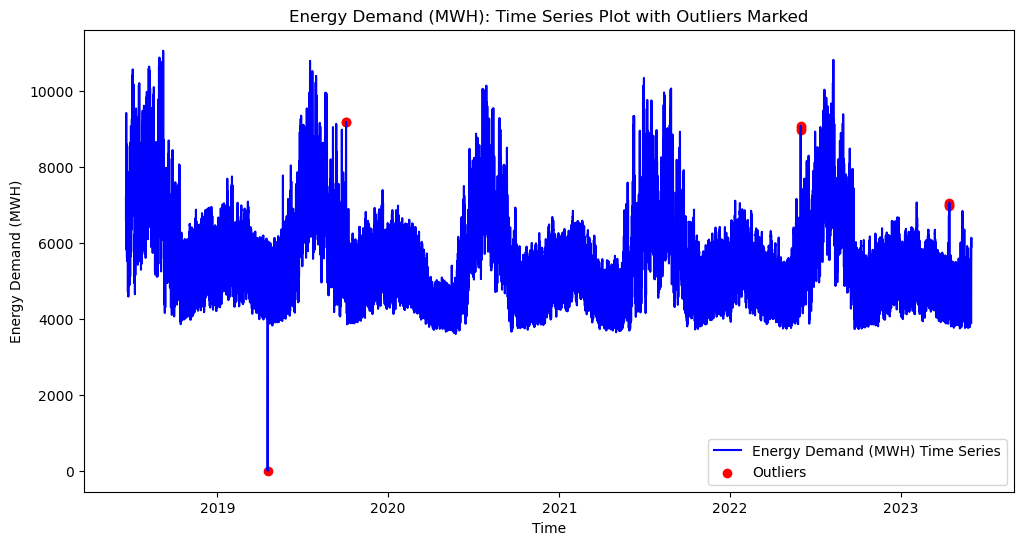

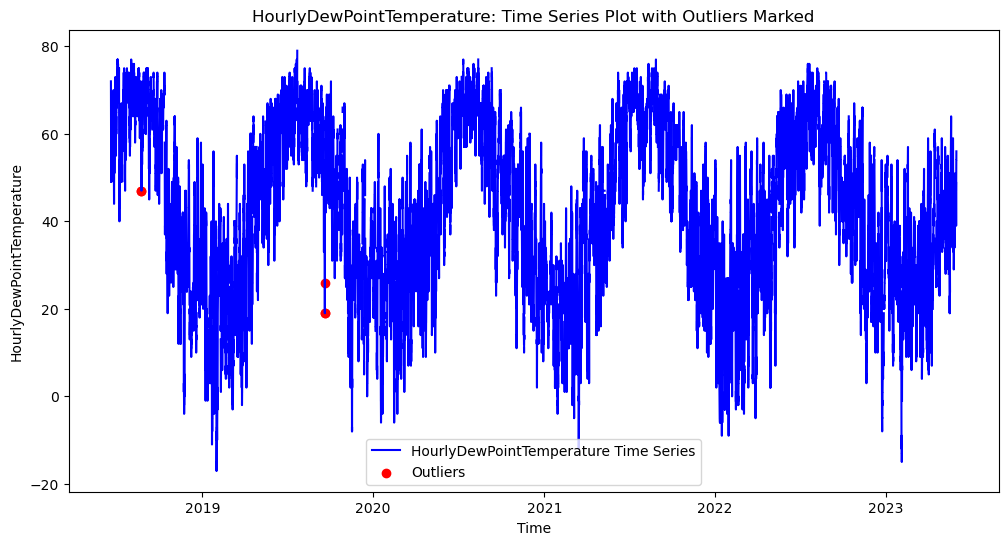

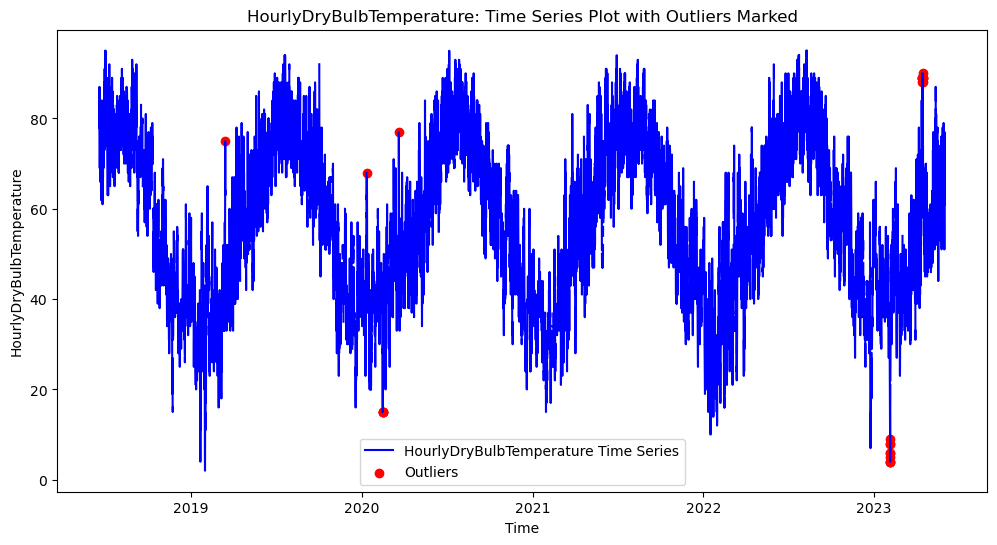

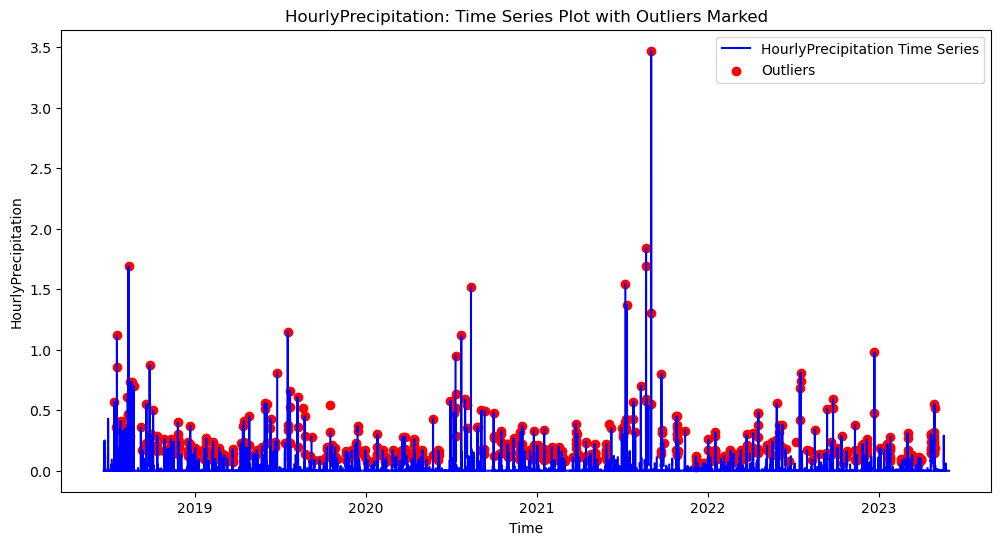

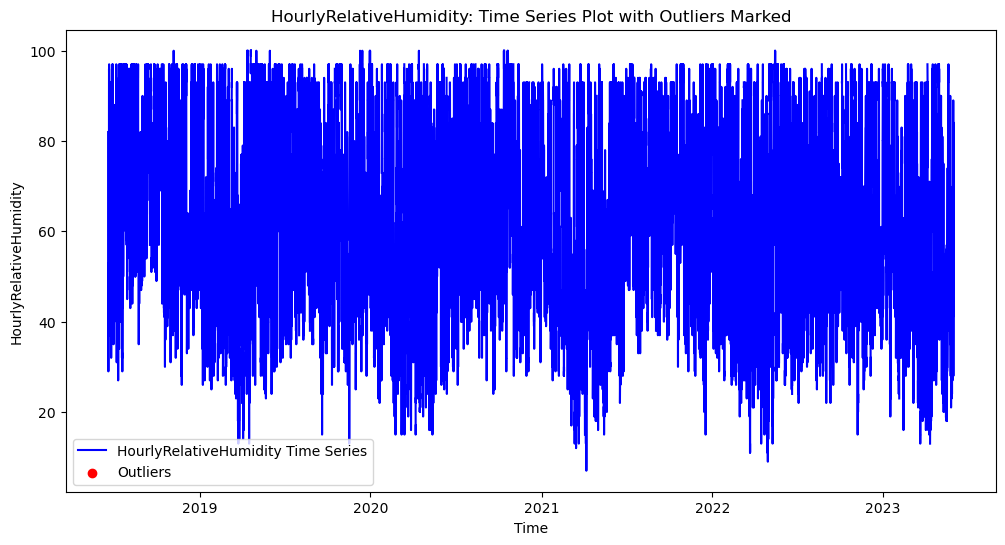

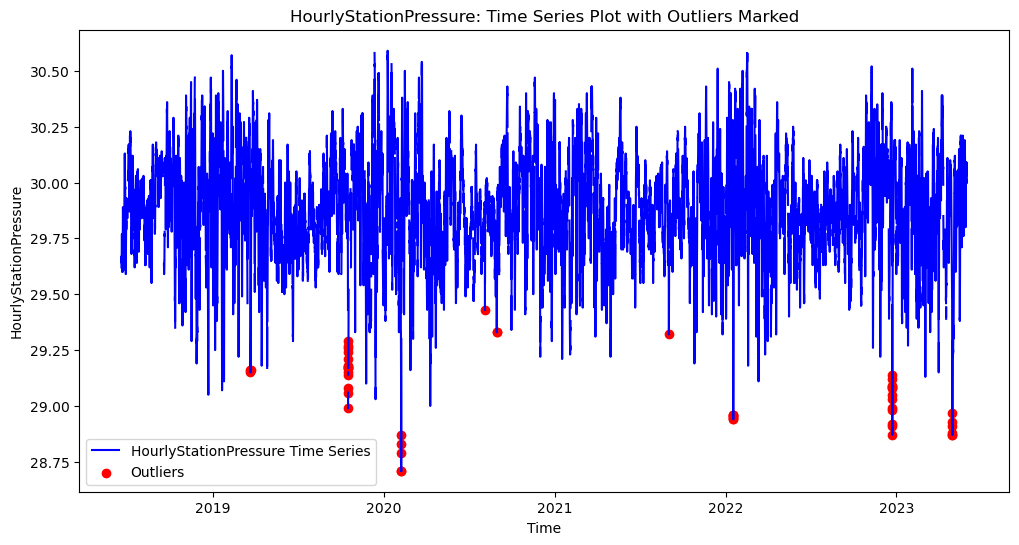

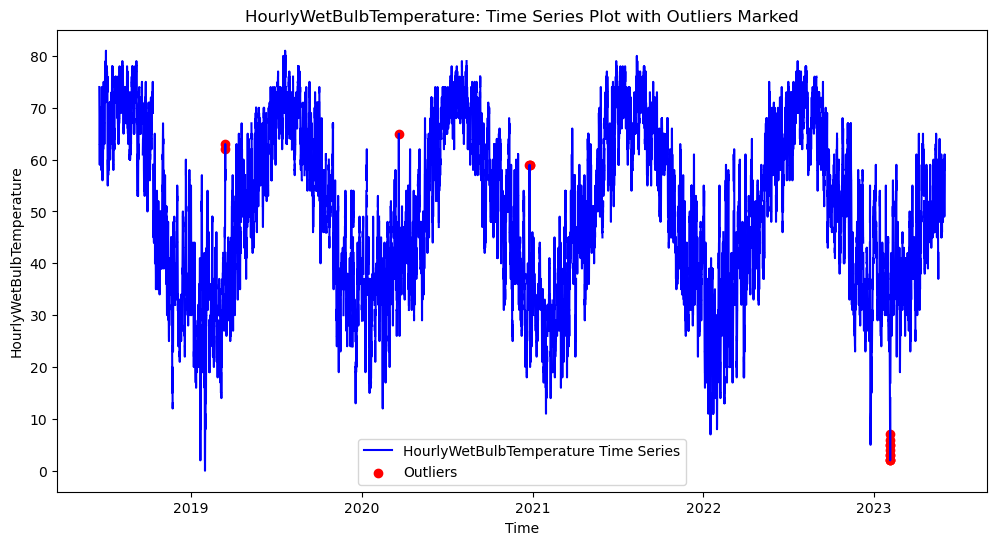

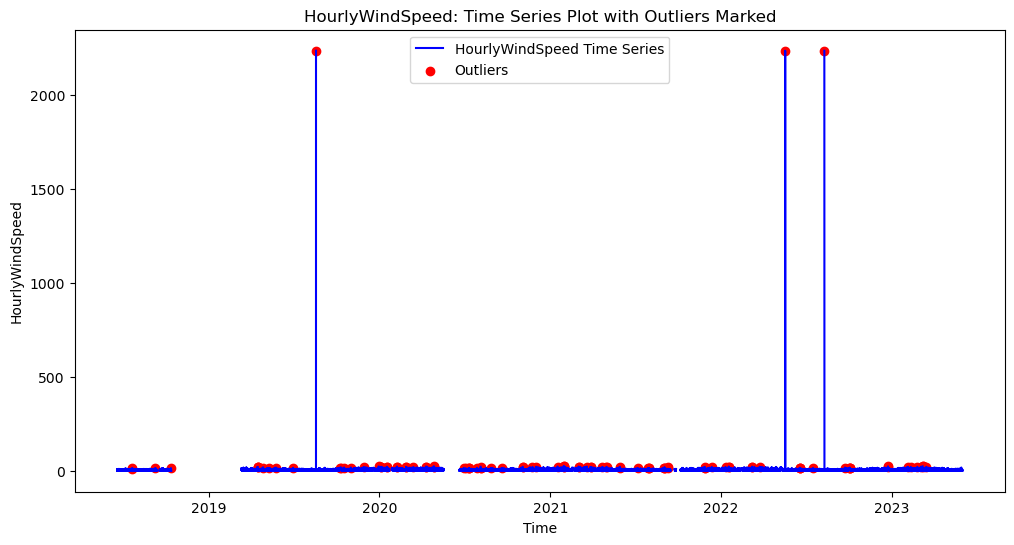

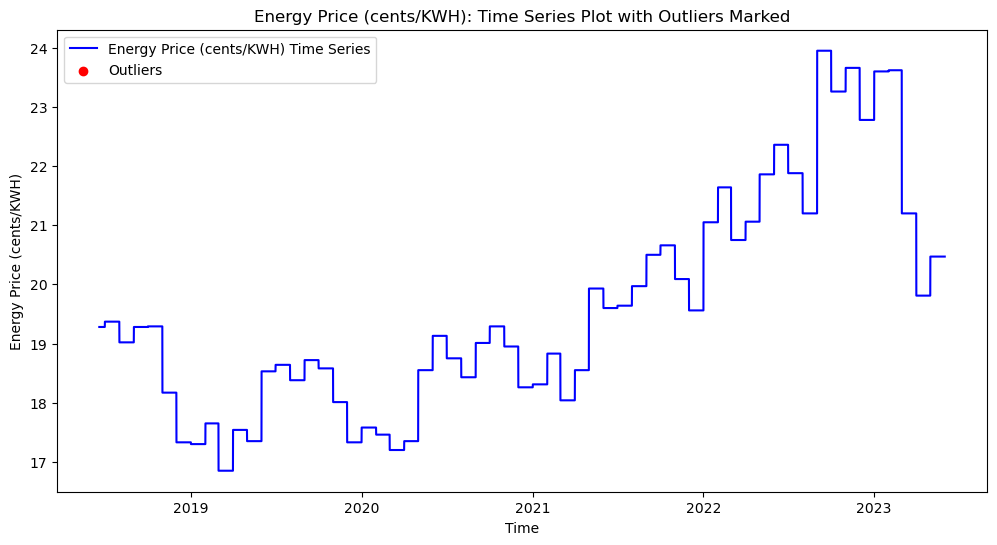

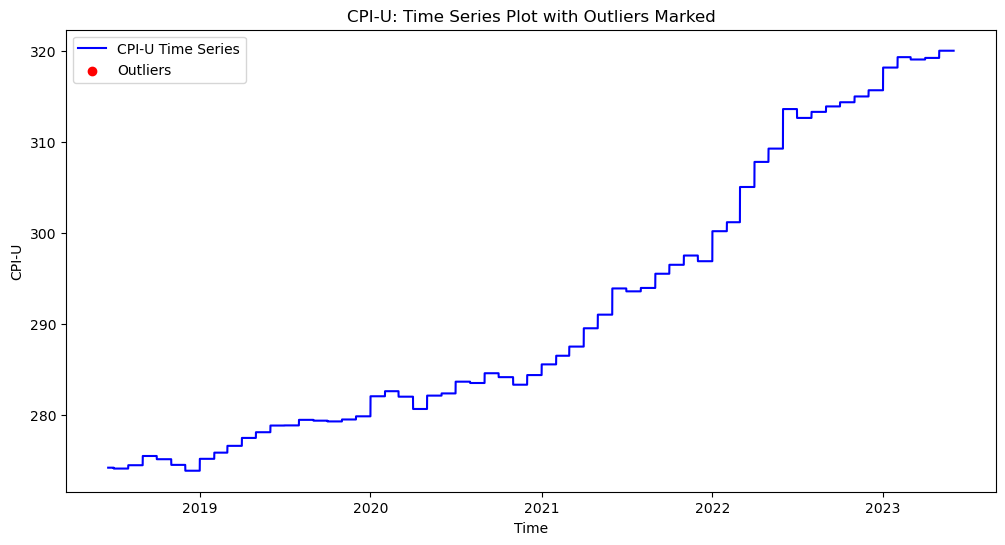

C:\Users\tbutler\AppData\Local\Temp\ipykernel_22656\546908620.py:23: RuntimeWarning: invalid value encountered in scalar divide
  z_score = (data[i] - mean) / std_dev


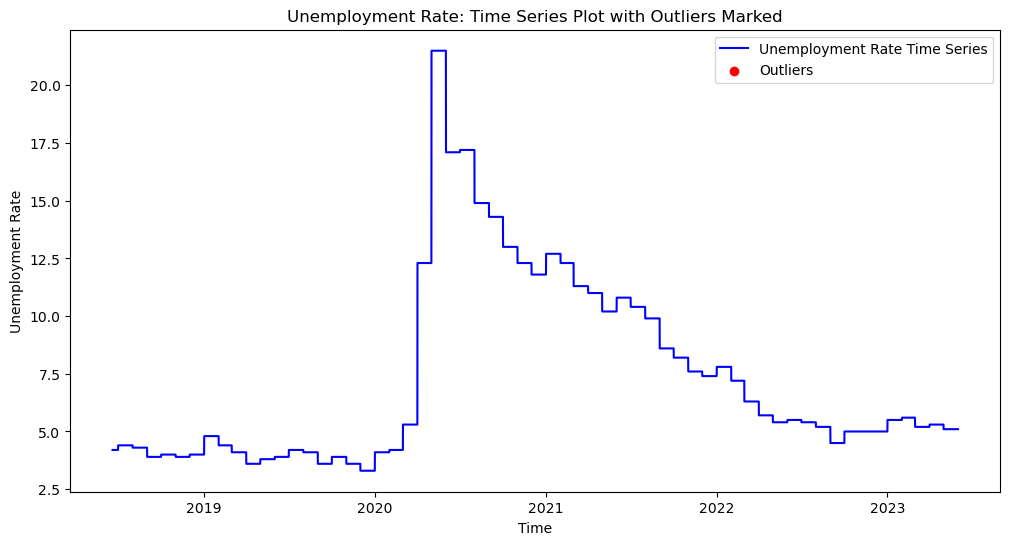

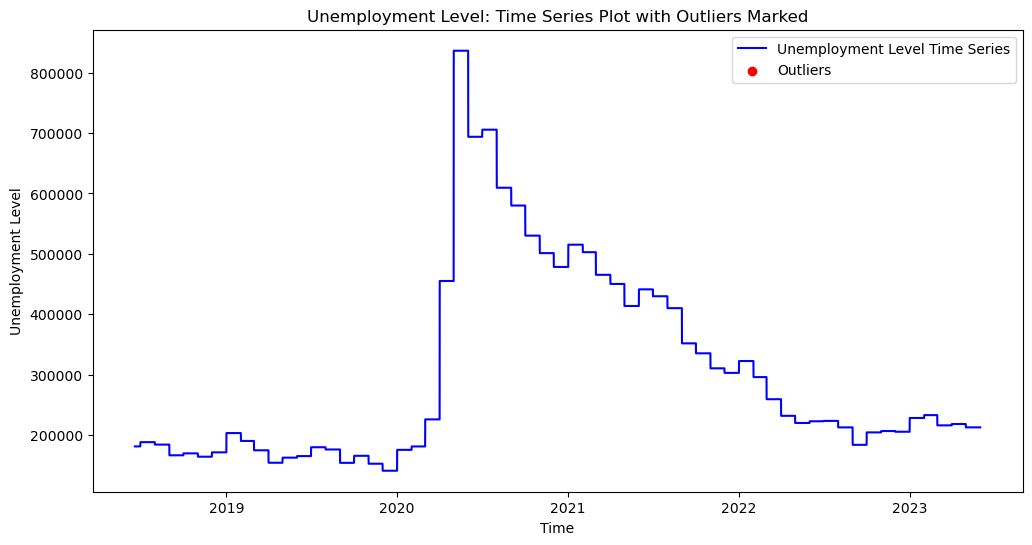

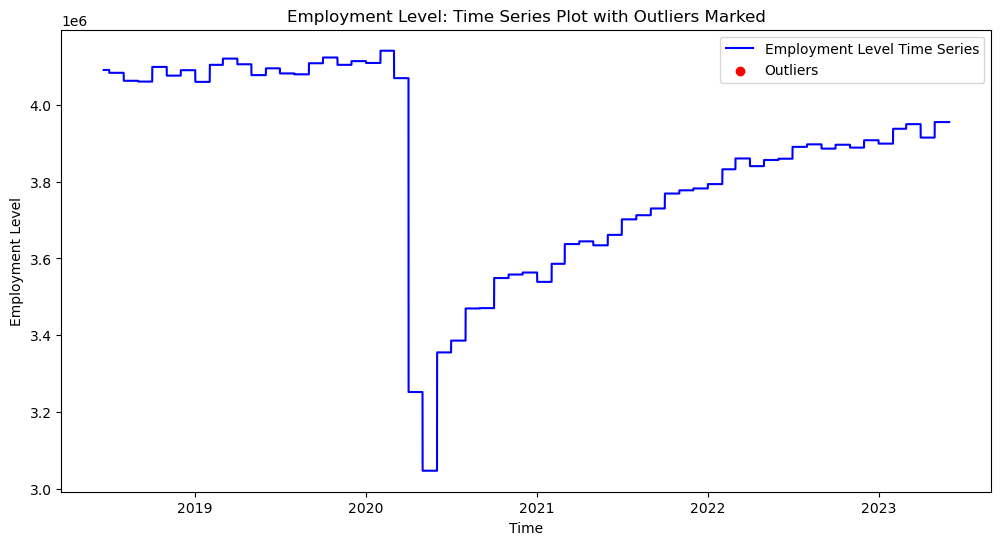

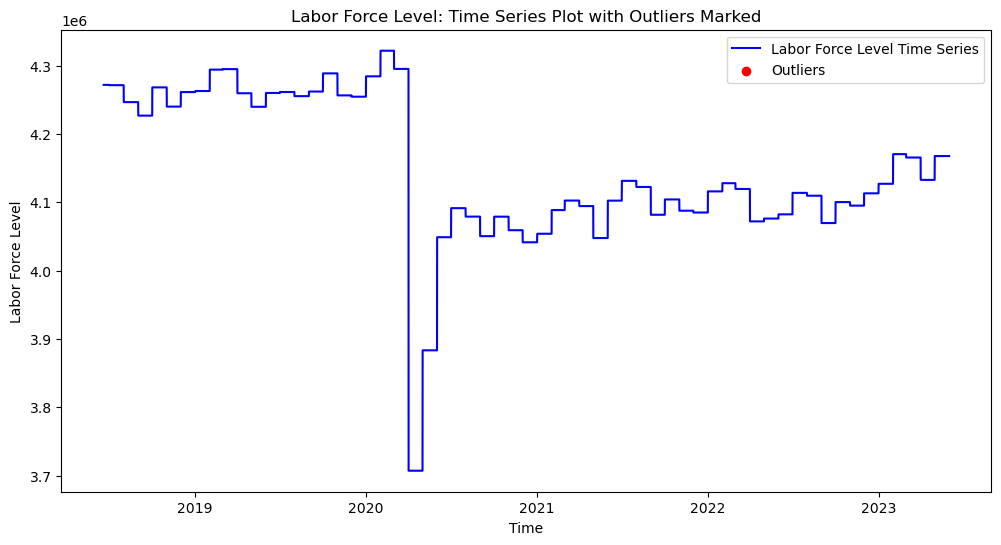

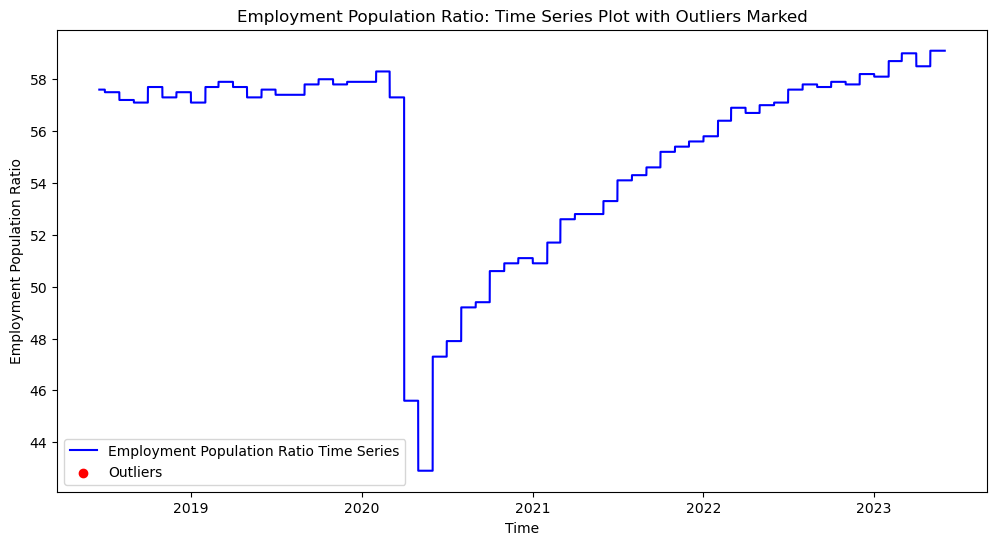

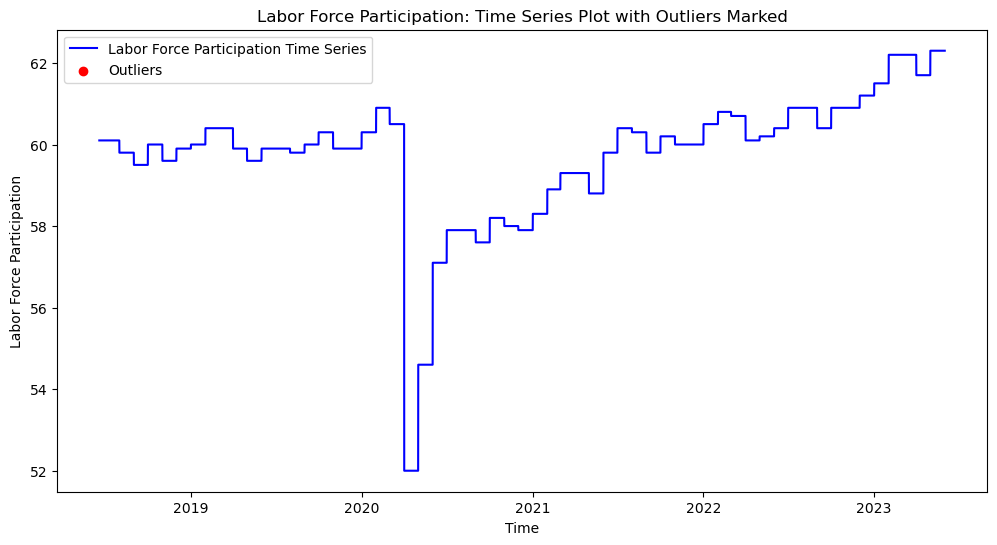

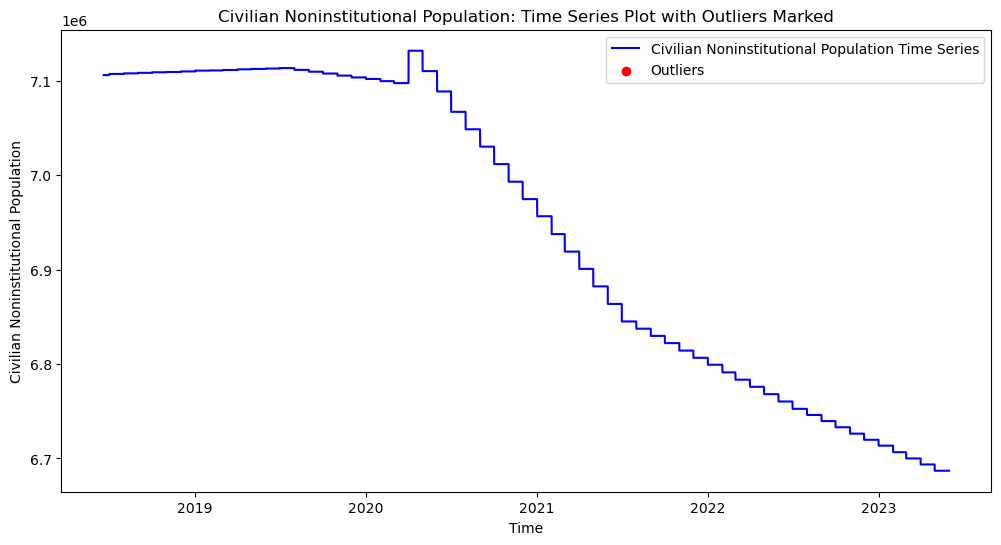

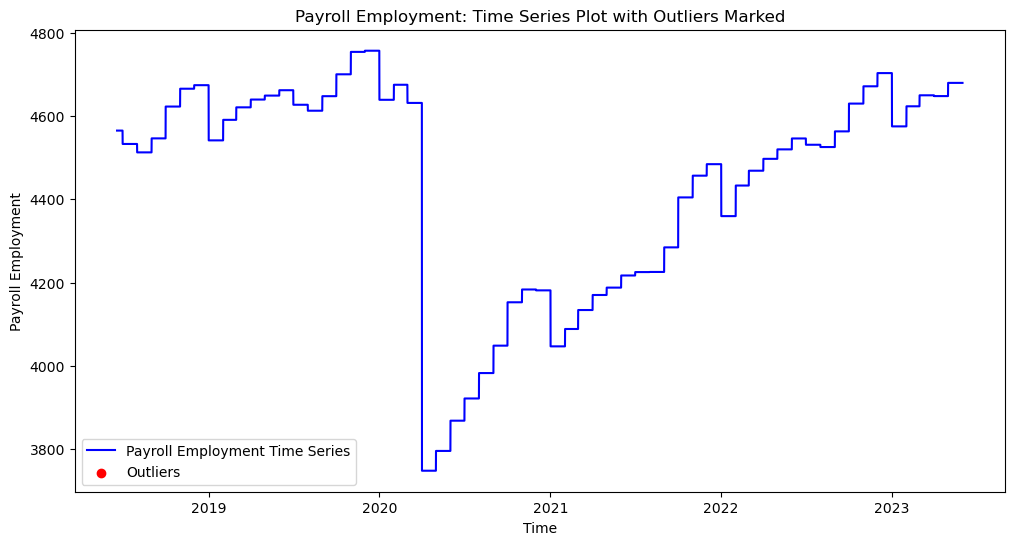

In [5]:
# Plot the time series with outliers marked
outliers_removed = training_data.copy()
for variable in training_data:
    ts = training_data[variable].copy()
    outliers = detect_outliers(ts, p=0.001, n=1000)
    plt.figure(figsize=(12, 6))
    plt.plot(ts, label=f'{variable} Time Series', color='blue')
    outliers_removed.loc[outliers, variable] = np.nan # replace outliers with NAN to remove them
    outliers = ts[outliers]
    plt.scatter(outliers.index, outliers, color='red', label='Outliers')
    plt.legend()
    plt.title(f'{variable}: Time Series Plot with Outliers Marked')
    plt.xlabel("Time")
    plt.ylabel(f"{variable}")
    plt.show()

In [6]:
# don't want to apply outlier detection to HourlyPrecipitation since it behaves more like a binary variable than a normally distributed one.

# Define bin edges and labels
bins = [-float('inf'), 0.0001, 0.05, 0.33, float('inf')]
labels = ['None', 'Light Rain', 'Medium Rain', 'Heavy Rain']

# Bin the 'values' column
outliers_removed.loc[:, "HourlyPrecipitation"] = pd.cut(training_data['HourlyPrecipitation'], bins=bins, labels=labels)

In [ ]:
# fill HourlyPrecipitation missing values with "None"

Find best fitting Prophet model for each variable

In [14]:
# get total number of periods available for training and cross validation
display(outliers_removed.shape[0])

# want to use five cross validation windows
num_cvs = 5
horizon_hours = (outliers_removed.shape[0]/2) // num_cvs
initial_hours = outliers_removed.shape[0] - (horizon_hours*num_cvs)
display(initial_hours)

43387

21697.0

In [15]:
variable = "Energy Demand (MWH)"

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# df_cv = cross_validation(model, initial=f'{initial_hours} hours', horizon=f'{horizon_hours} hours', parallel="processes")
df = outliers_removed[[variable]].reset_index().rename(columns={"index":"ds", variable:"y"})

# Use cross validation to evaluate all parameters
for params in all_params:
    model = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(model, initial=f'{initial_hours} hours', horizon=f'{horizon_hours} hours', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    print("{}: {}".format(str(params), df_p['rmse']))

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

11:45:18 - cmdstanpy - INFO - Chain [1] start processing


KeyboardInterrupt: 

Use Prophet model to impute missing values for each variable

In [152]:
prophet_models = {}
interpolations = {}
clean_data = outliers_removed.copy()
for variable in [x for x in clean_data.columns if x not in ["HourlyPrecipitation"]]:
    print(f"Interpolating for variable {variable}")
    model = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=True, 
        changepoint_prior_scale=0.01, seasonality_prior_scale=1)
    df = outliers_removed[[variable]].reset_index().rename(columns={"index":"ds", variable:"y"})
    results = model.fit(df)
    prophet_models[variable] = model
    interpolated_values = model.predict(df)
    interpolations[variable] = interpolated_values
    to_impute = outliers_removed[variable].isna().values
    clean_data.loc[to_impute, variable] = interpolated_values["yhat"][to_impute].values

Interpolating for variable Energy Demand (MWH)


21:52:32 - cmdstanpy - INFO - Chain [1] start processing
21:52:44 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyDewPointTemperature


21:53:06 - cmdstanpy - INFO - Chain [1] start processing
21:53:11 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyDryBulbTemperature


21:53:34 - cmdstanpy - INFO - Chain [1] start processing
21:53:39 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyRelativeHumidity


21:54:02 - cmdstanpy - INFO - Chain [1] start processing
21:54:05 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyStationPressure


21:54:27 - cmdstanpy - INFO - Chain [1] start processing
21:54:42 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyWetBulbTemperature


21:55:05 - cmdstanpy - INFO - Chain [1] start processing
21:55:09 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyWindSpeed


21:55:30 - cmdstanpy - INFO - Chain [1] start processing
21:55:33 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Energy Price (cents/KWH)


21:55:56 - cmdstanpy - INFO - Chain [1] start processing
21:56:59 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable CPI-U


21:57:21 - cmdstanpy - INFO - Chain [1] start processing
21:58:12 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Unemployment Rate


21:58:34 - cmdstanpy - INFO - Chain [1] start processing
21:59:33 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Unemployment Level


22:00:03 - cmdstanpy - INFO - Chain [1] start processing
22:01:22 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Employment Level


22:01:45 - cmdstanpy - INFO - Chain [1] start processing
22:03:05 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Labor Force Level


22:03:27 - cmdstanpy - INFO - Chain [1] start processing
22:04:14 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Employment Population Ratio


22:04:38 - cmdstanpy - INFO - Chain [1] start processing
22:05:40 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Labor Force Participation


22:06:03 - cmdstanpy - INFO - Chain [1] start processing
22:06:58 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Civilian Noninstitutional Population


22:07:20 - cmdstanpy - INFO - Chain [1] start processing
22:08:05 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Payroll Employment


22:08:27 - cmdstanpy - INFO - Chain [1] start processing
22:09:10 - cmdstanpy - INFO - Chain [1] done processing


Visualize variable distributions and decompositions

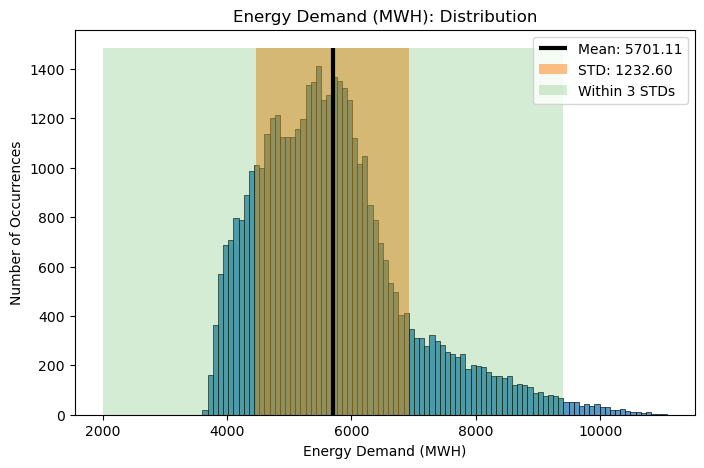

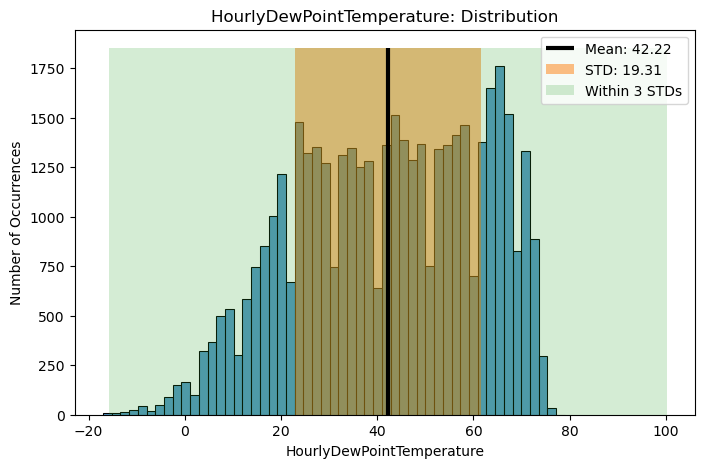

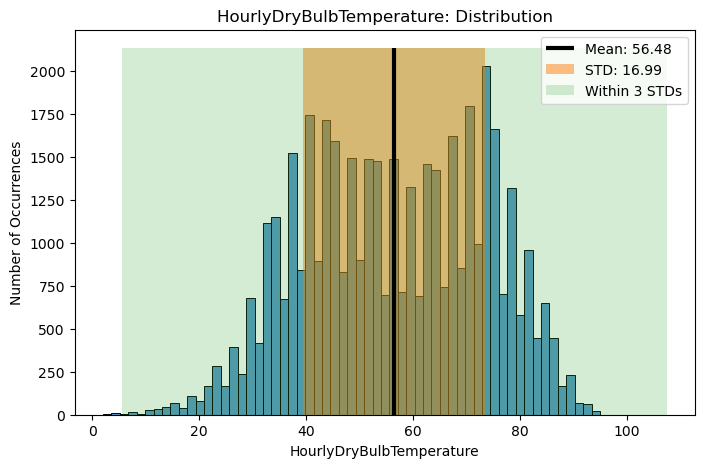

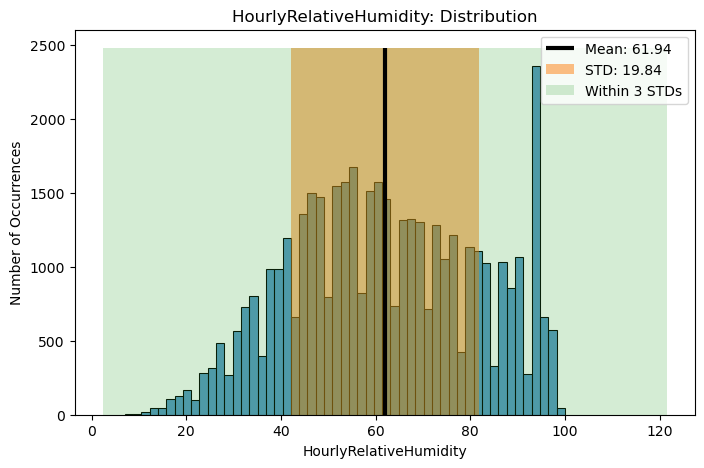

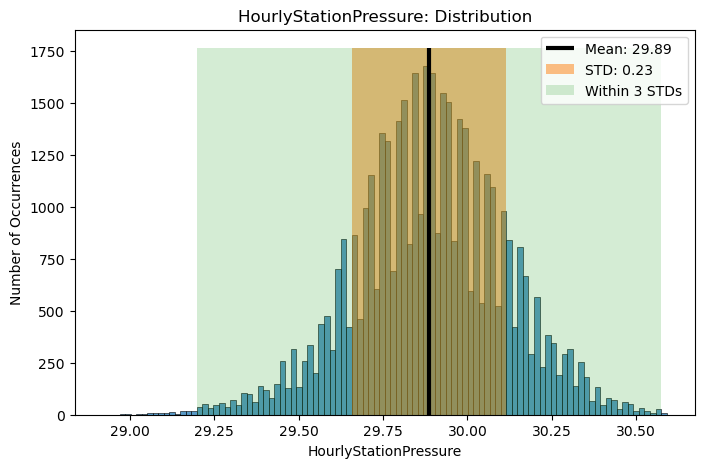

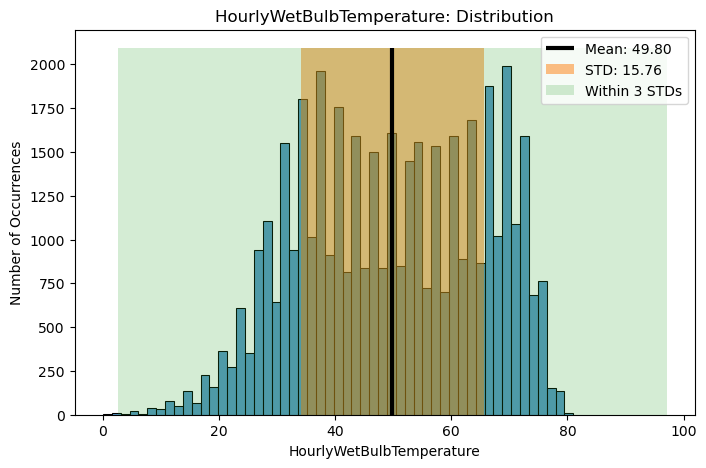

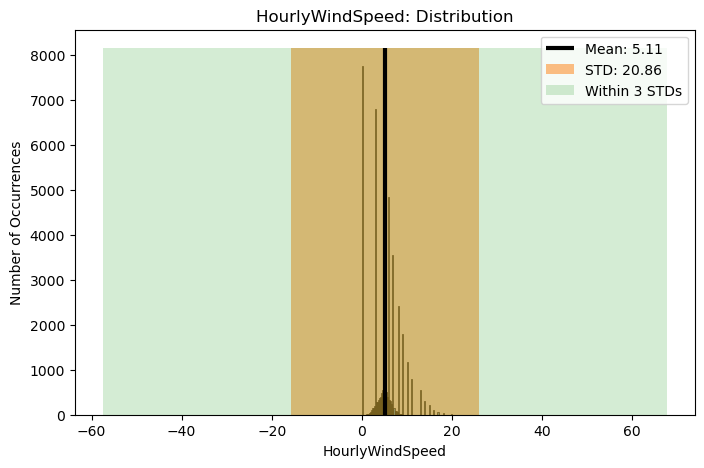

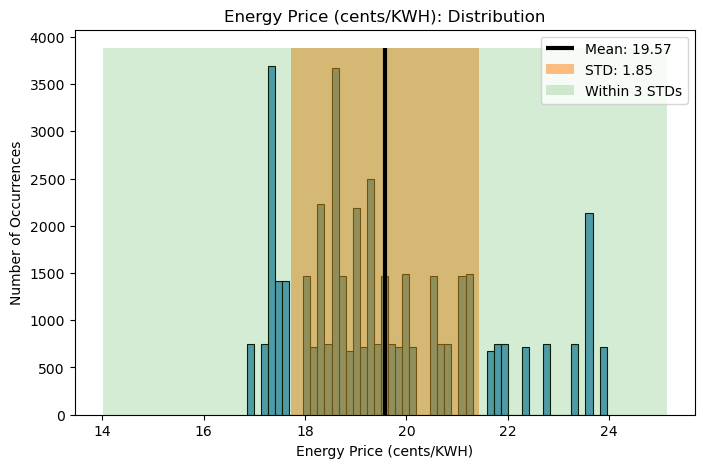

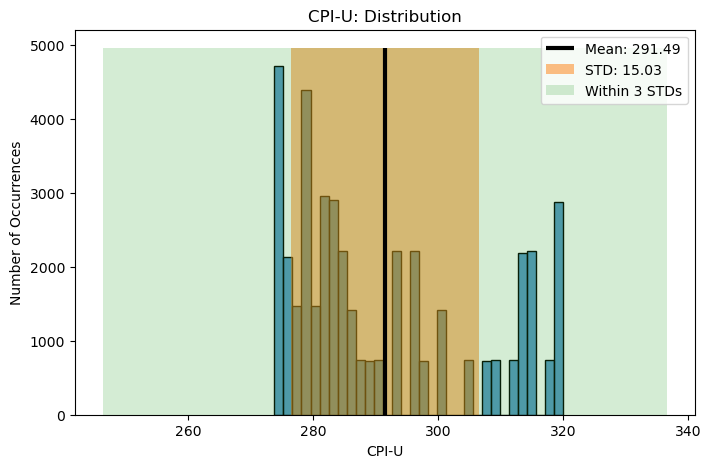

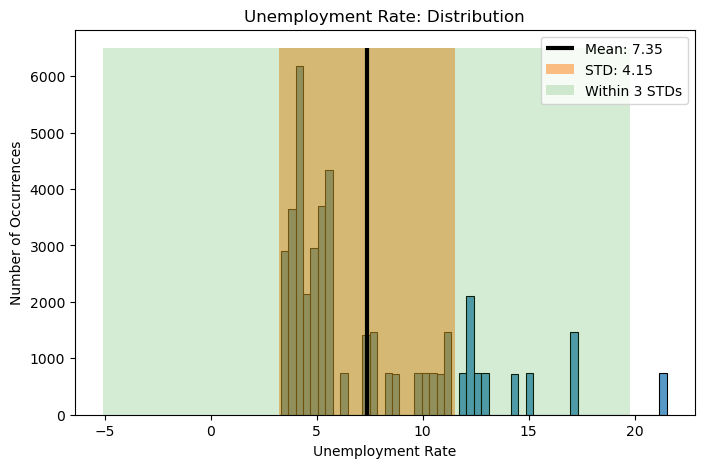

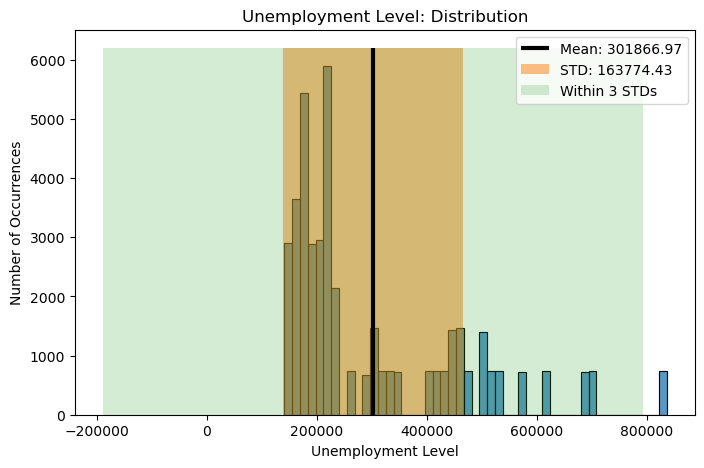

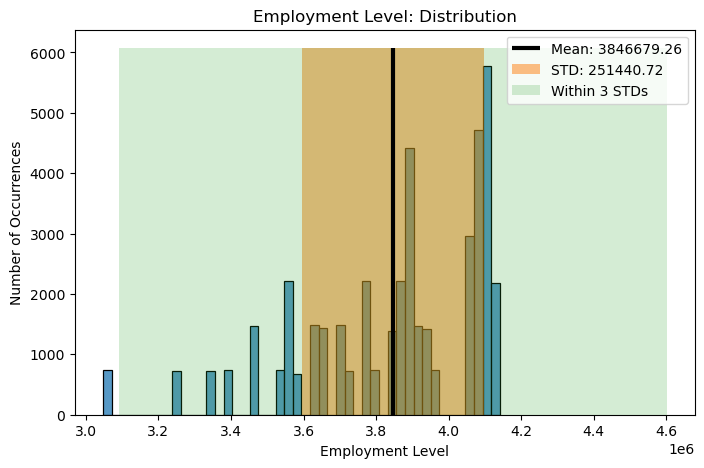

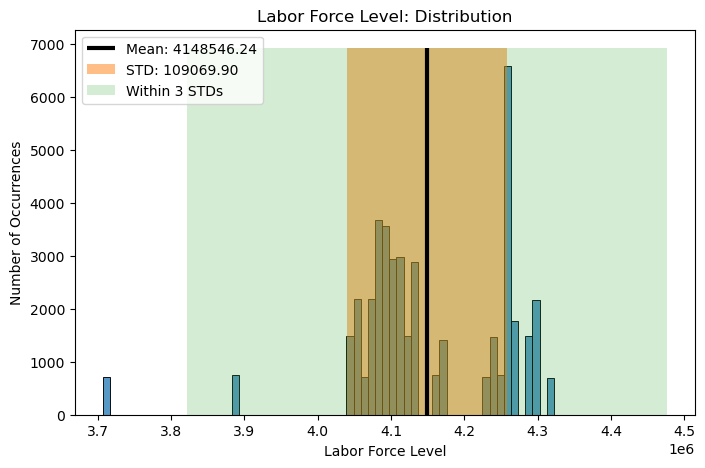

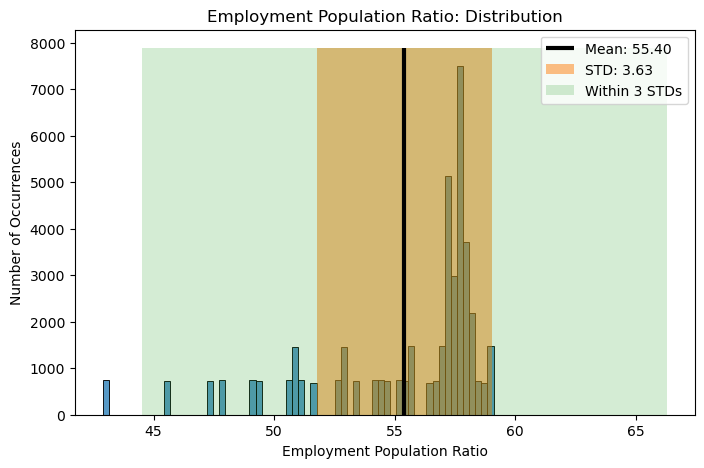

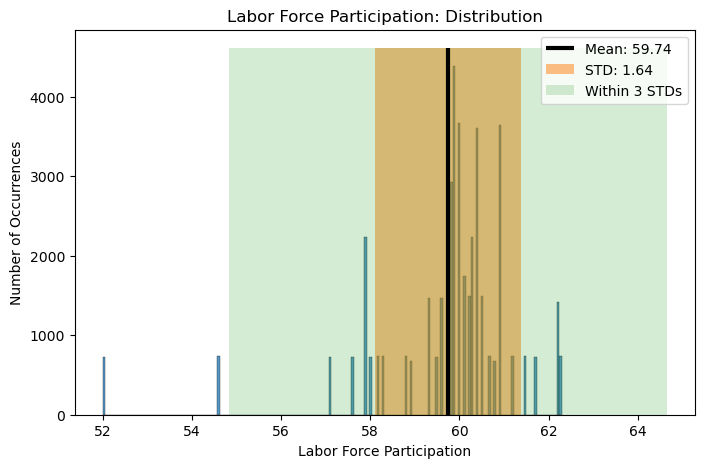

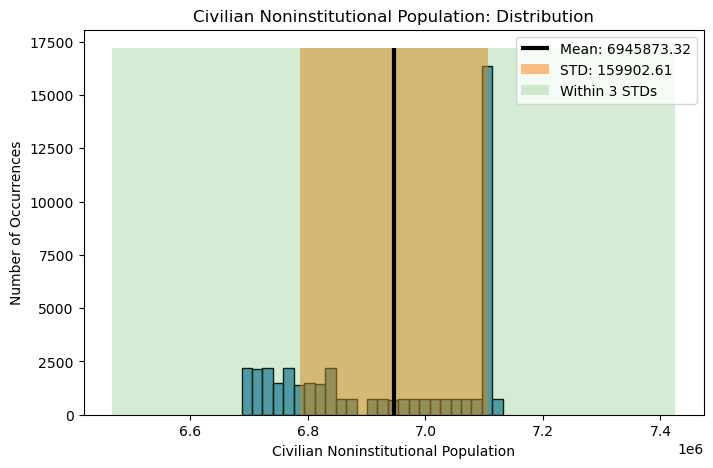

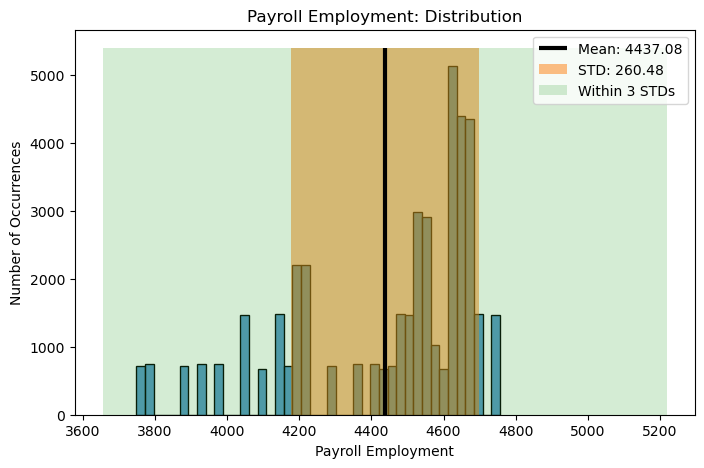

In [115]:
for variable in [x for x in clean_data.columns if x not in ["HourlyPrecipitation"]]:
    # calculate mean and standard deviation
    mean = training_data[variable].mean()
    std = training_data[variable].std()
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot()
    sns.histplot(clean_data[variable])
    ax.set_title(f"{variable}: Distribution")
    ax.set_xlabel(variable)
    ax.set_ylabel("Number of Occurrences")
    ylim = ax.get_ylim()
    ax.vlines(x=mean, ymin=ylim[0], ymax=ylim[1], color="black", linewidth=3, label="Mean: {:.2f}".format(mean))
    ax.fill_between(x=[mean-std, mean+std], y1=ylim[0], y2=ylim[1], alpha=0.5, label="STD: {:.2f}".format(std))
    ax.fill_between(x=[mean-3*std, mean+3*std], y1=ylim[0], y2=ylim[1], alpha=0.2, label="Within 3 STDs".format(std))
    ax.legend()

In [121]:
display(clean_data["HourlyPrecipitation"].value_counts())

None           36504
Light Rain      2260
Medium Rain     1077
Heavy Rain       112
Name: HourlyPrecipitation, dtype: int64

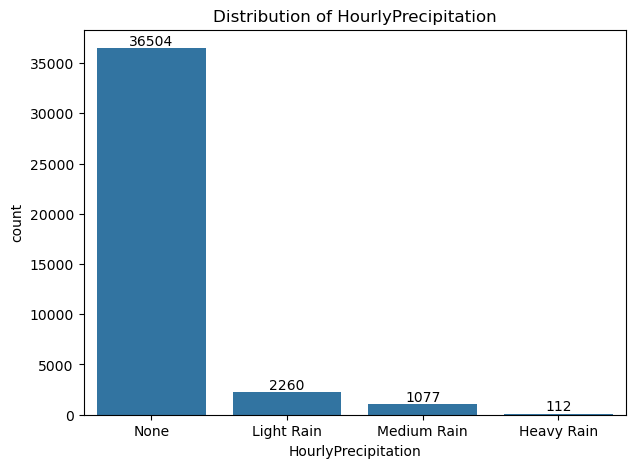

In [127]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot()
sns.countplot(x=clean_data["HourlyPrecipitation"])
ax.set_title("Distribution of HourlyPrecipitation")
ax.bar_label(ax.containers[0])
ax.set_ylabel("Number of Observations")
plt.show()

### Basic Time Series Plots

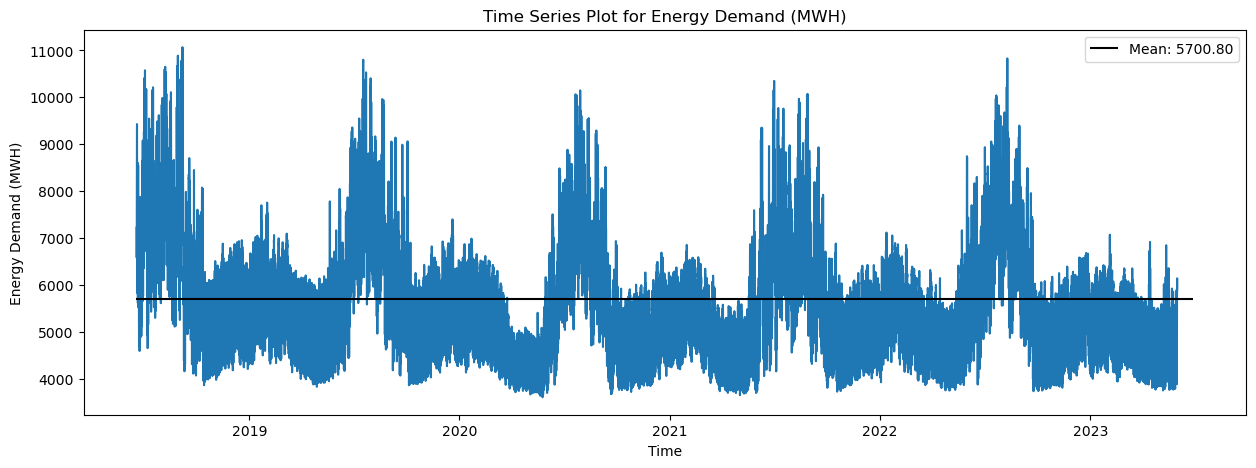

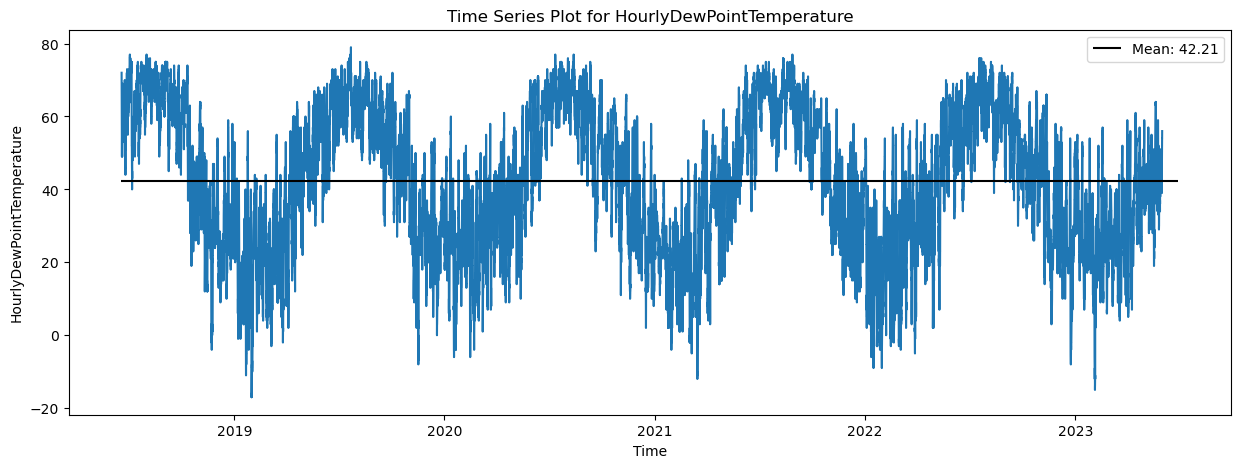

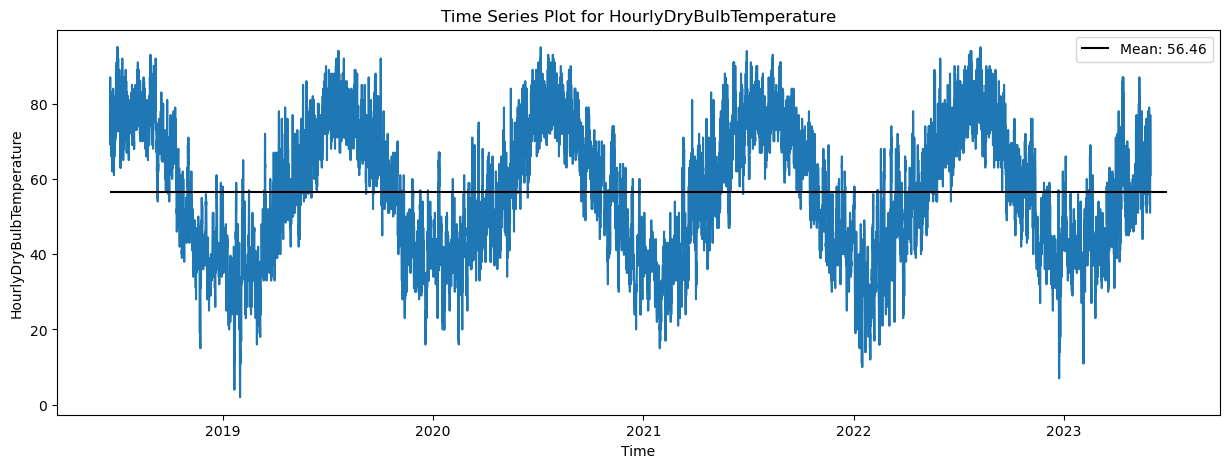

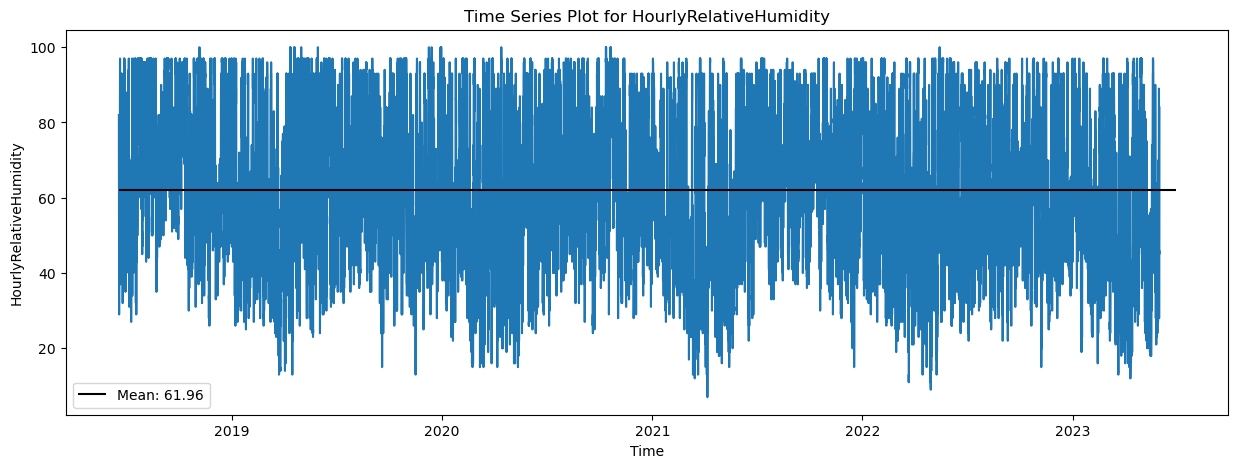

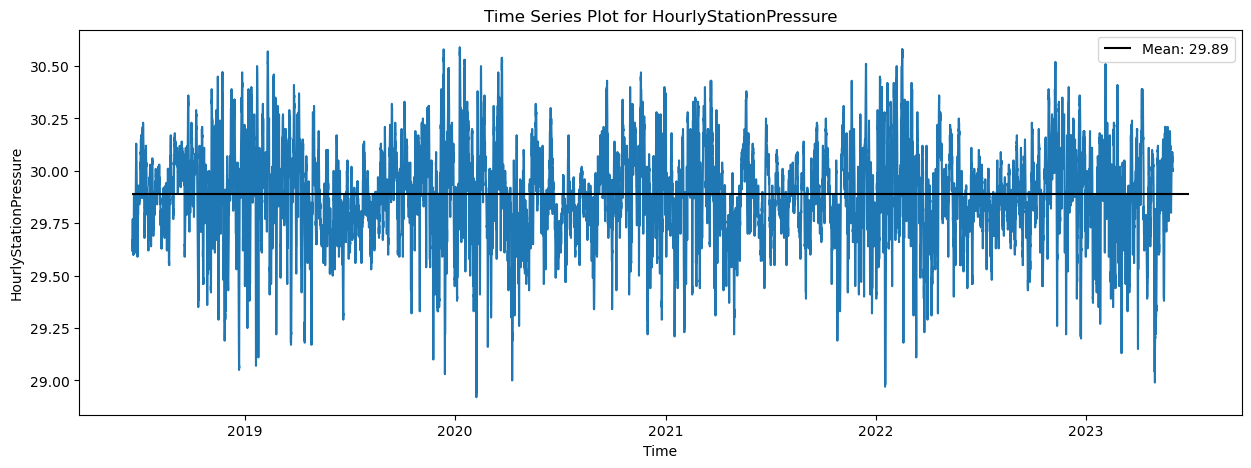

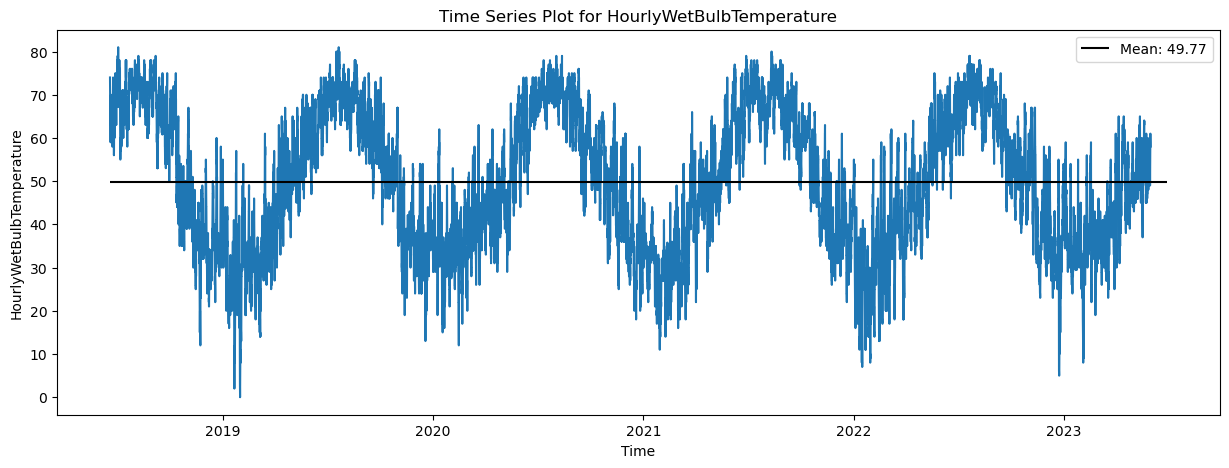

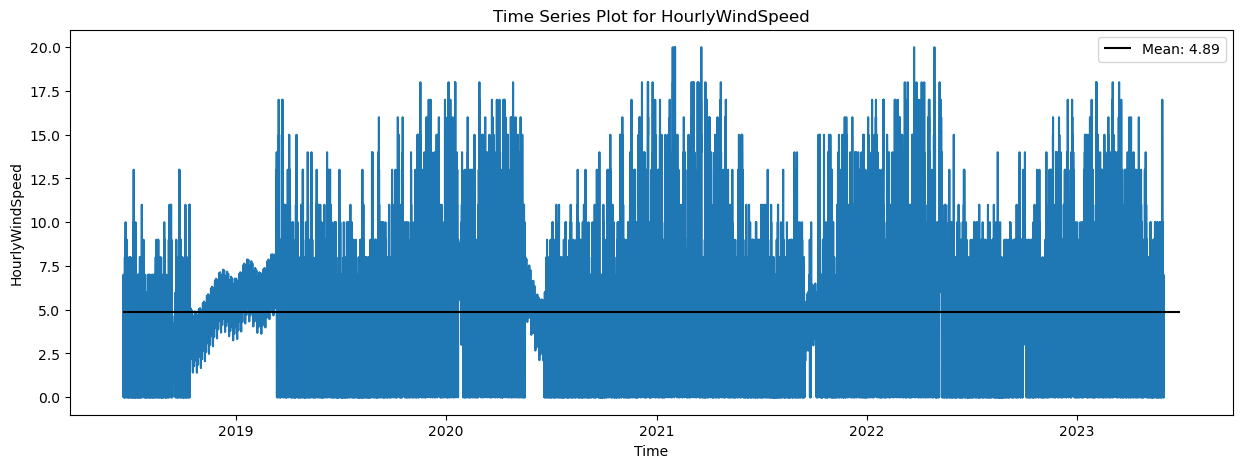

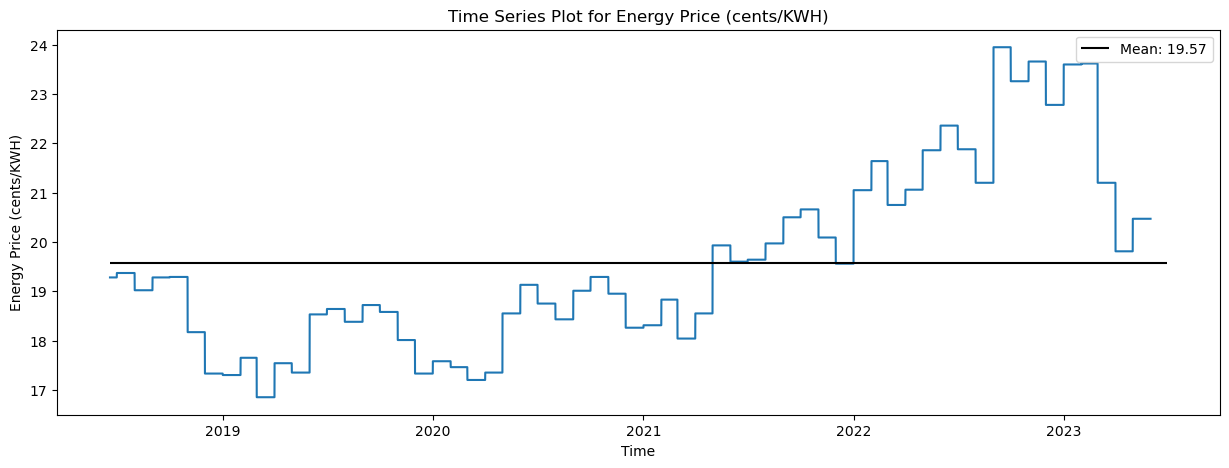

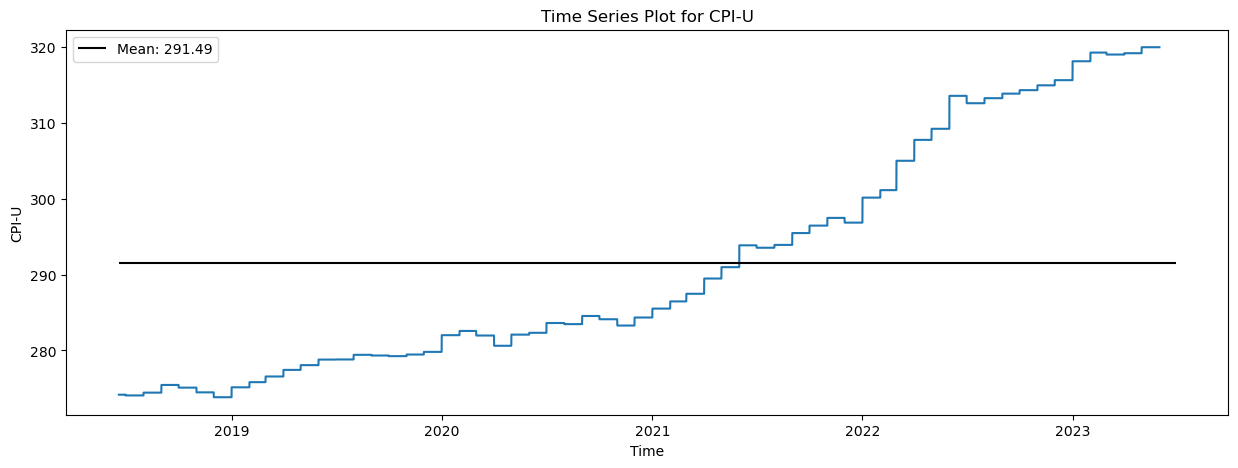

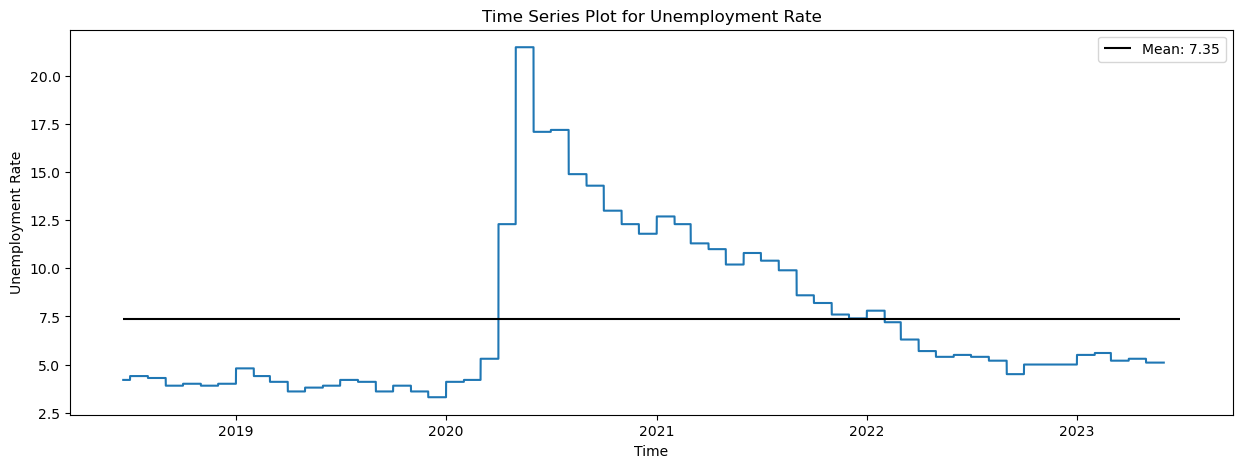

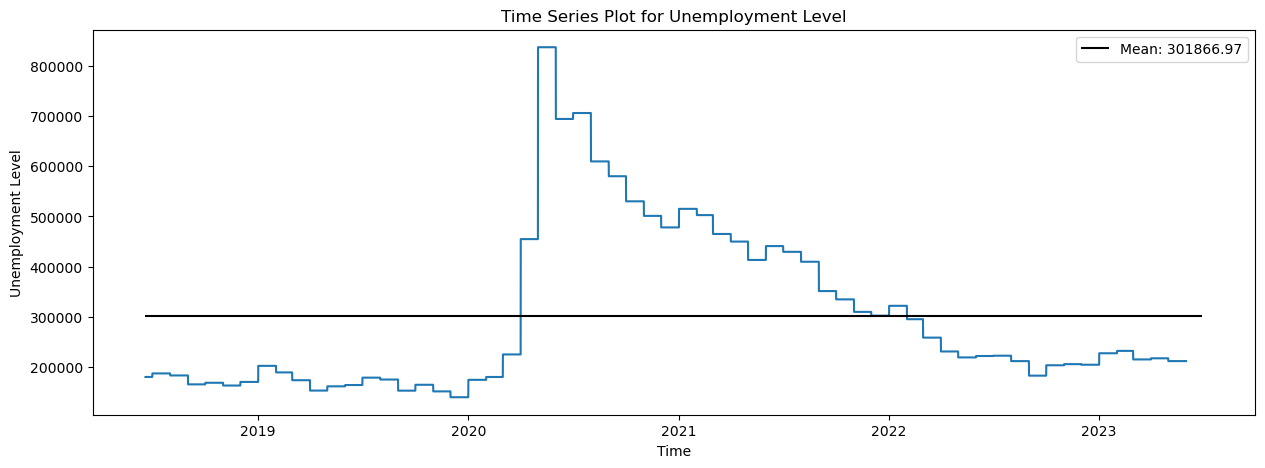

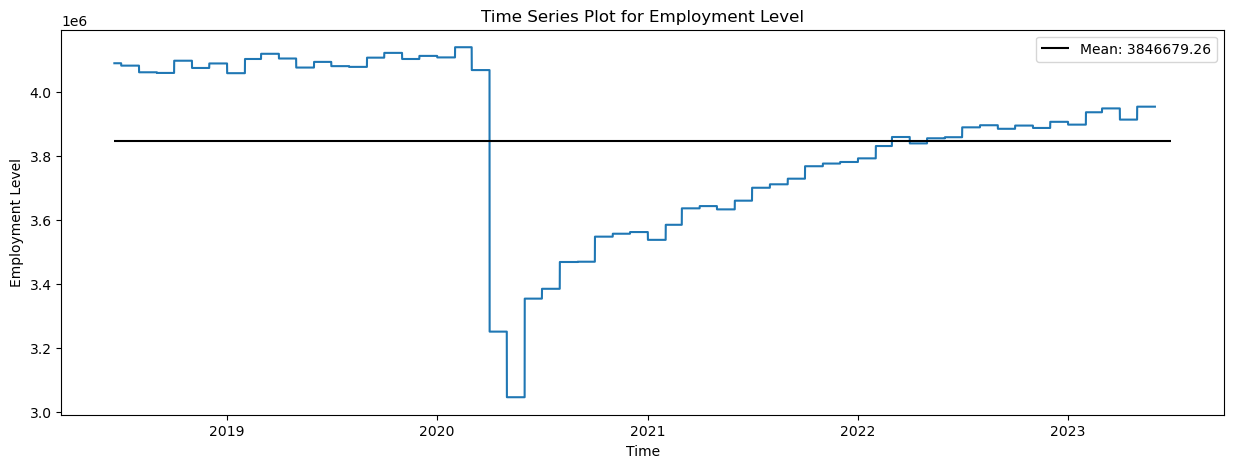

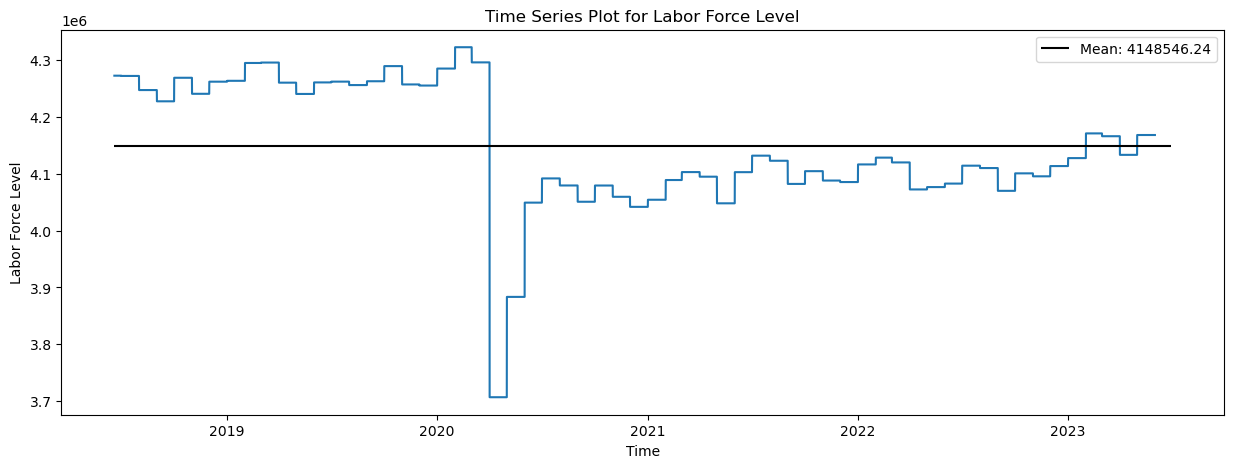

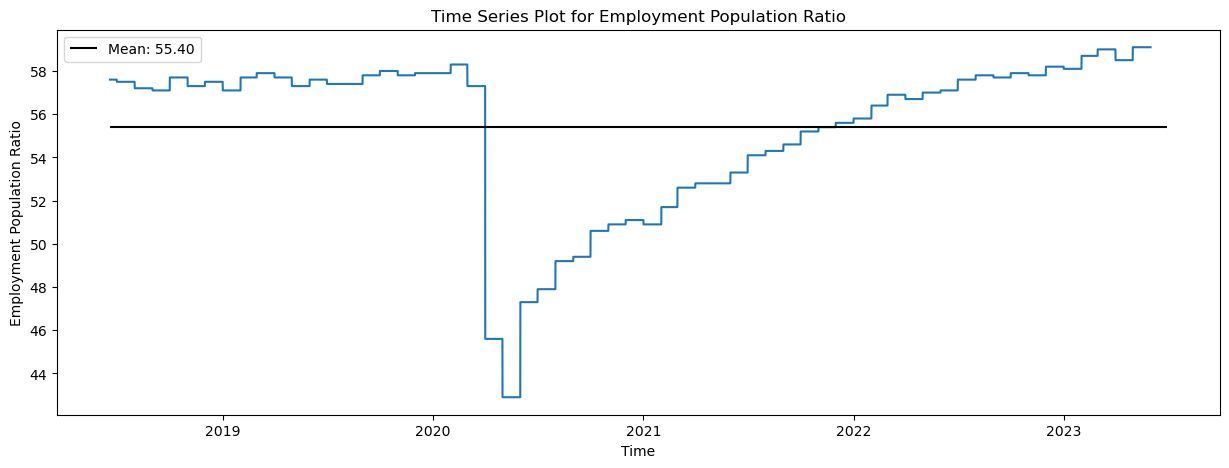

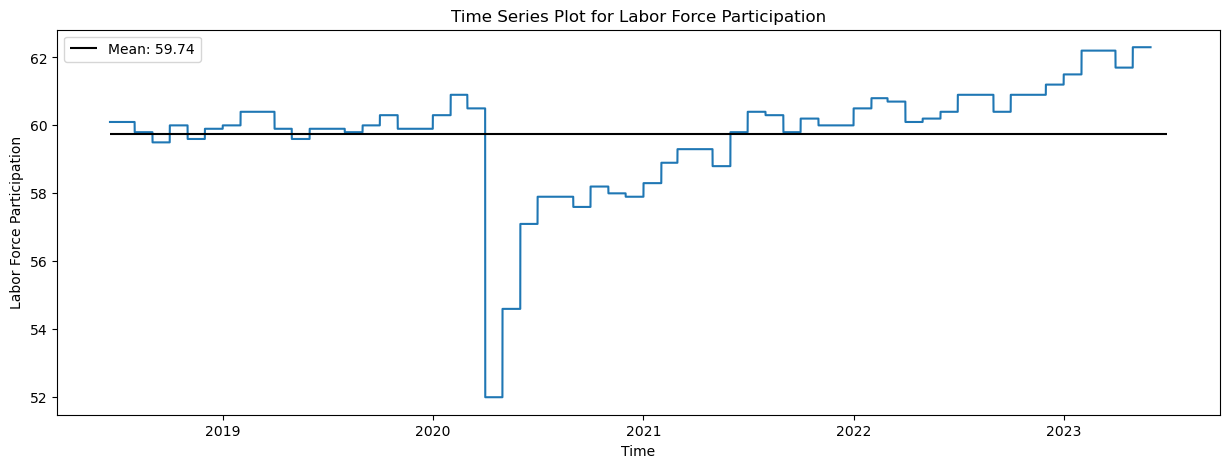

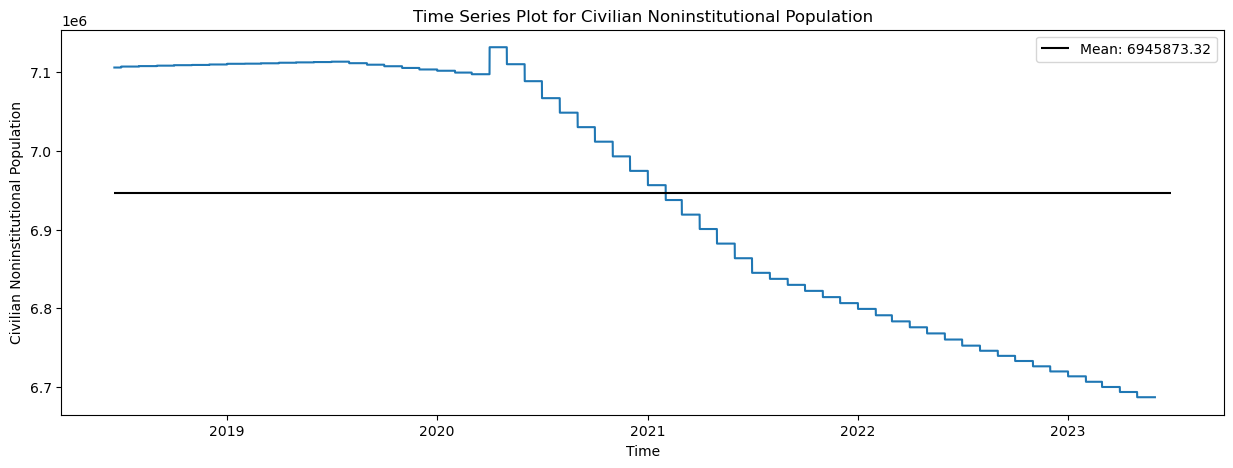

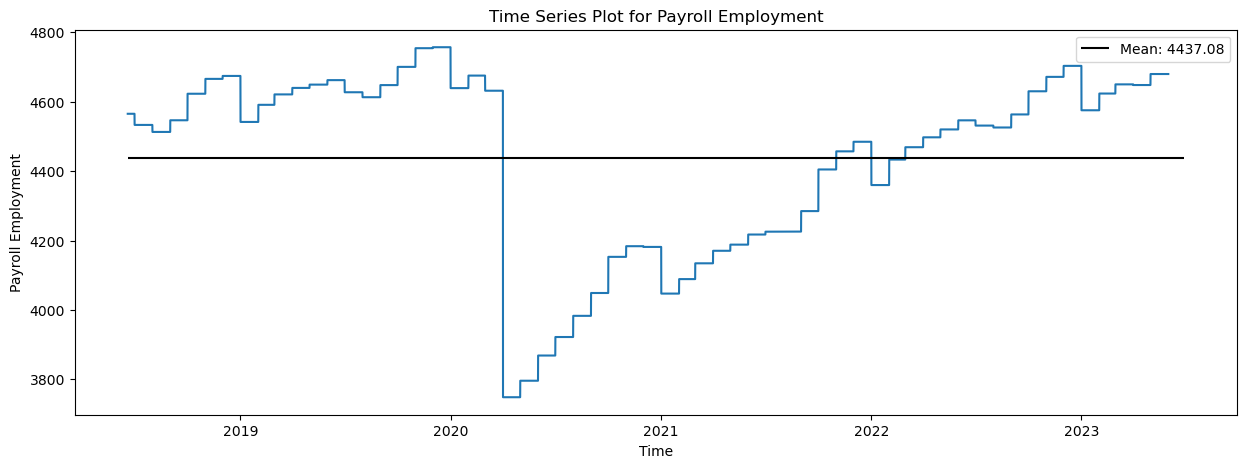

In [151]:
for variable in [x for x in clean_data.columns if x not in ["HourlyPrecipitation"]]:
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot()
    ax.plot(clean_data[variable])
    ax.set_title("Time Series Plot for {}".format(variable))
    ax.set_xlabel("Time")
    ax.set_ylabel(variable)
    # ax.hlines(y=clean_data[variable].mean(), xmin=2018, xmax=2024)
    ax.hlines(y=clean_data[variable].mean(), xmin=np.datetime64("2018-06-19"), xmax=np.datetime64("2023-06-29"), color="black", label="Mean: {:.2f}".format(clean_data[variable].mean()))
    ax.legend()
    plt.show()

    # sns.lineplot(x=clean_data.index, y=clean_data[variable])
    # plt.hlines(y=clean_data[variable].mean(), xmin=clean_data.index.min(), xmax=clean_data.index.max())

Time Series Decomposition Plots for those with Seasonality

In [74]:
display(clean_data.columns)

Index(['Energy Demand (MWH)', 'HourlyDewPointTemperature',
       'HourlyDryBulbTemperature', 'HourlyPrecipitation',
       'HourlyRelativeHumidity', 'HourlyStationPressure',
       'HourlyWetBulbTemperature', 'HourlyWindSpeed',
       'Energy Price (cents/KWH)', 'CPI-U', 'Unemployment Rate',
       'Unemployment Level', 'Employment Level', 'Labor Force Level',
       'Employment Population Ratio', 'Labor Force Participation',
       'Civilian Noninstitutional Population', 'Payroll Employment'],
      dtype='object')

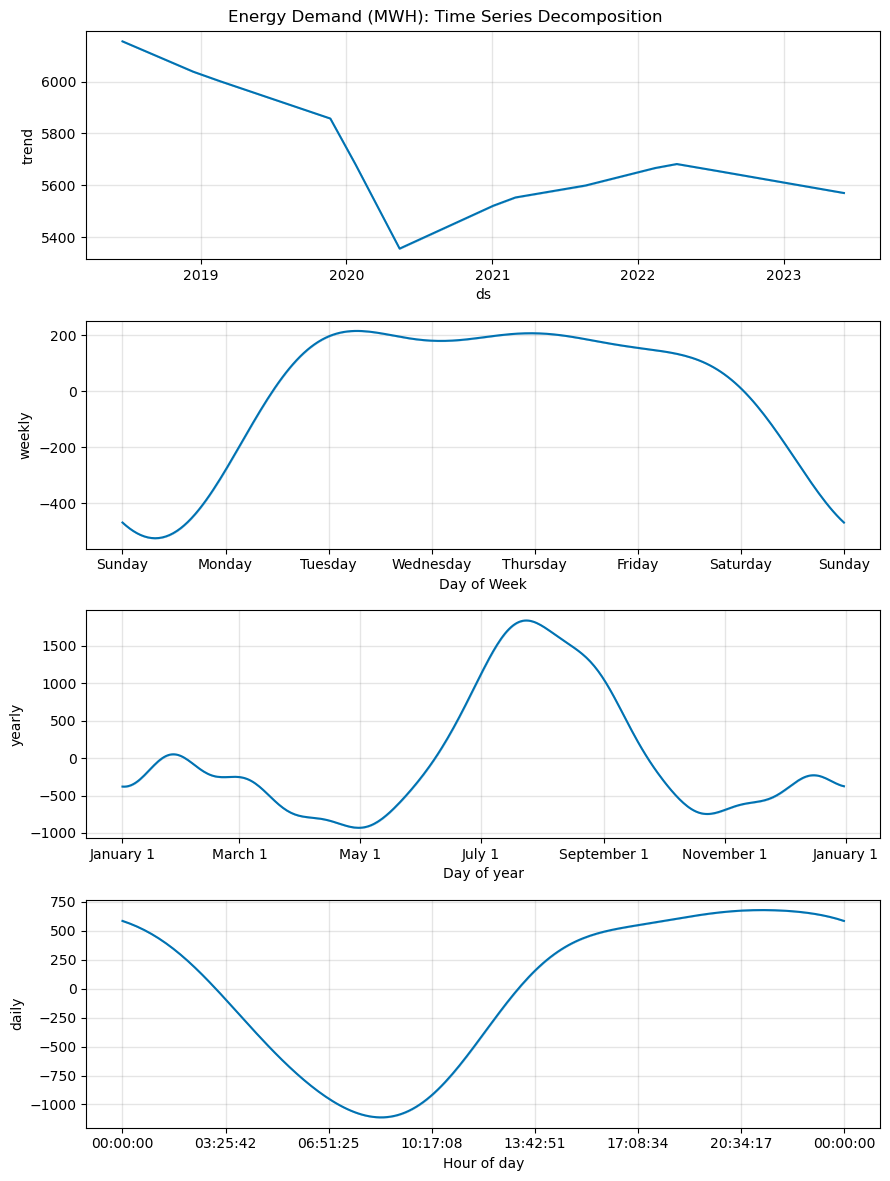

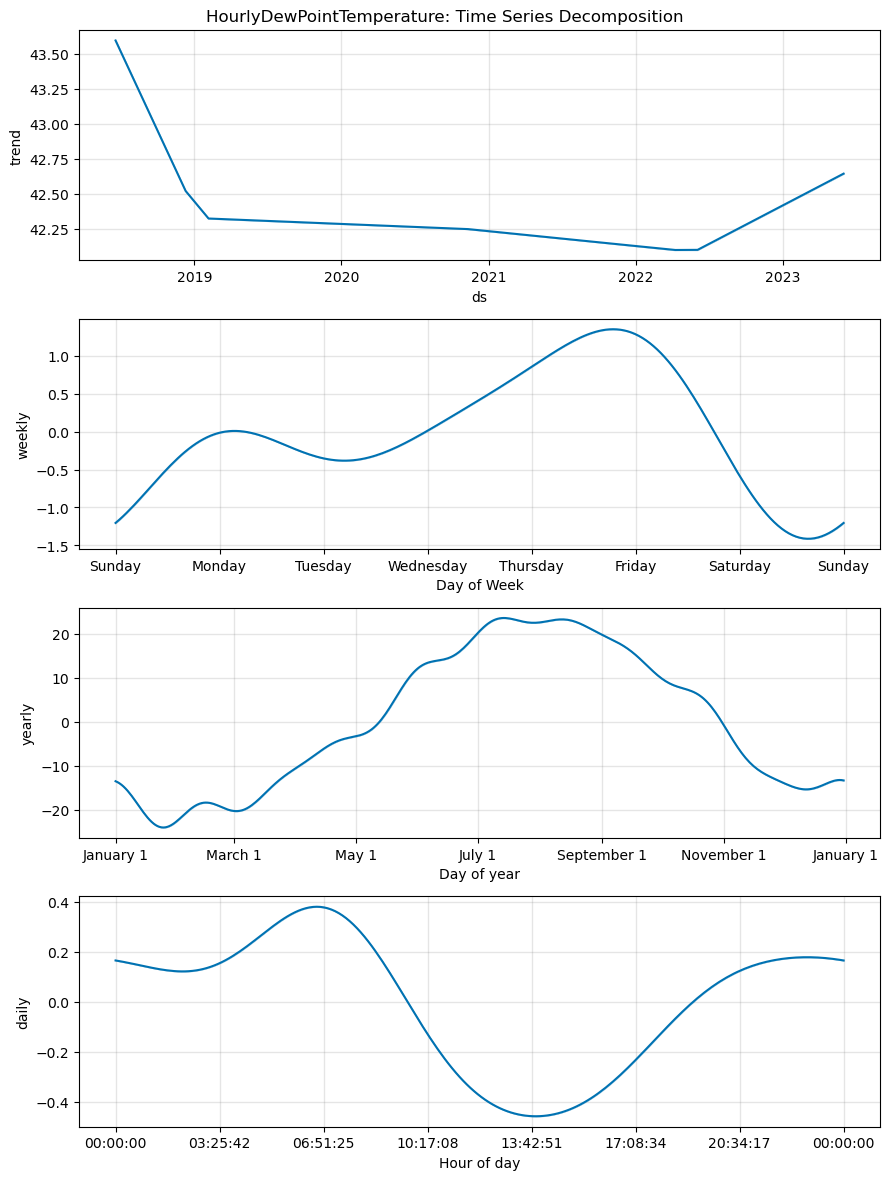

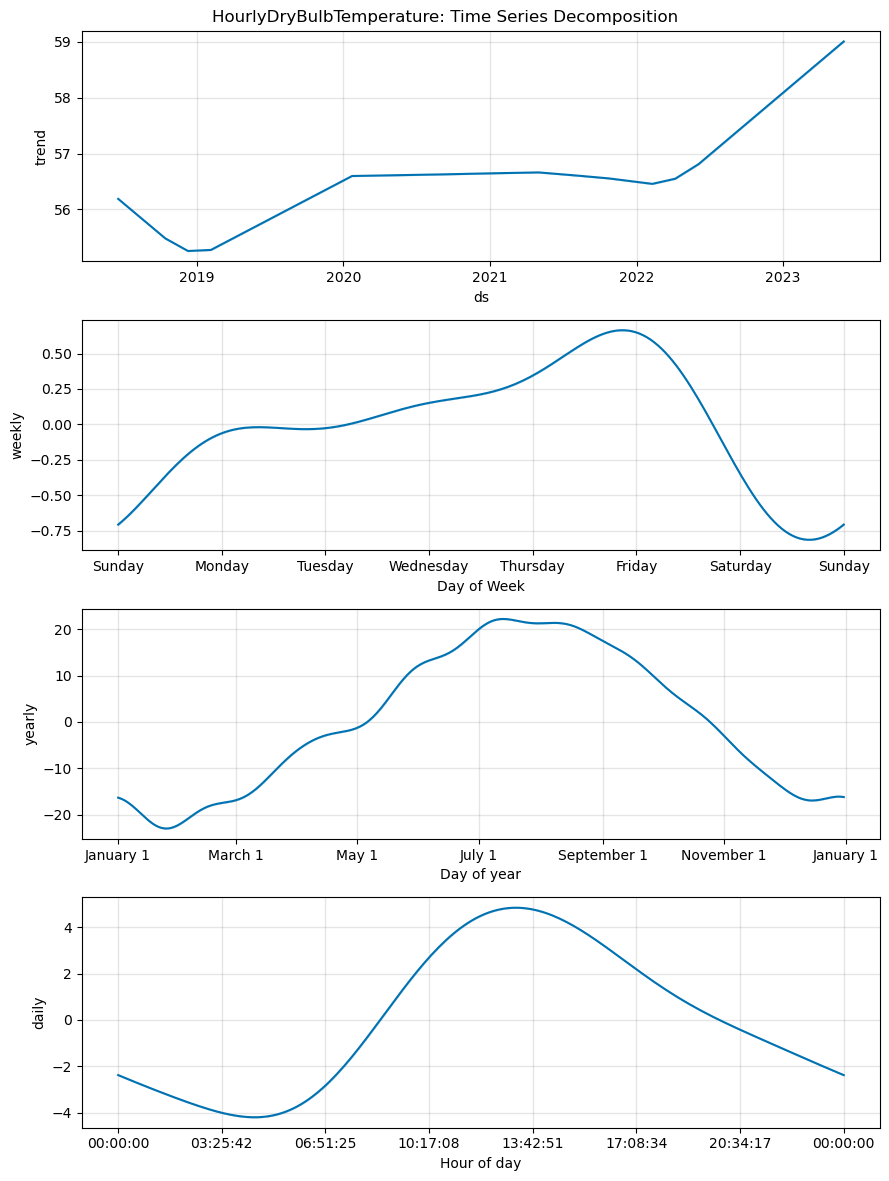

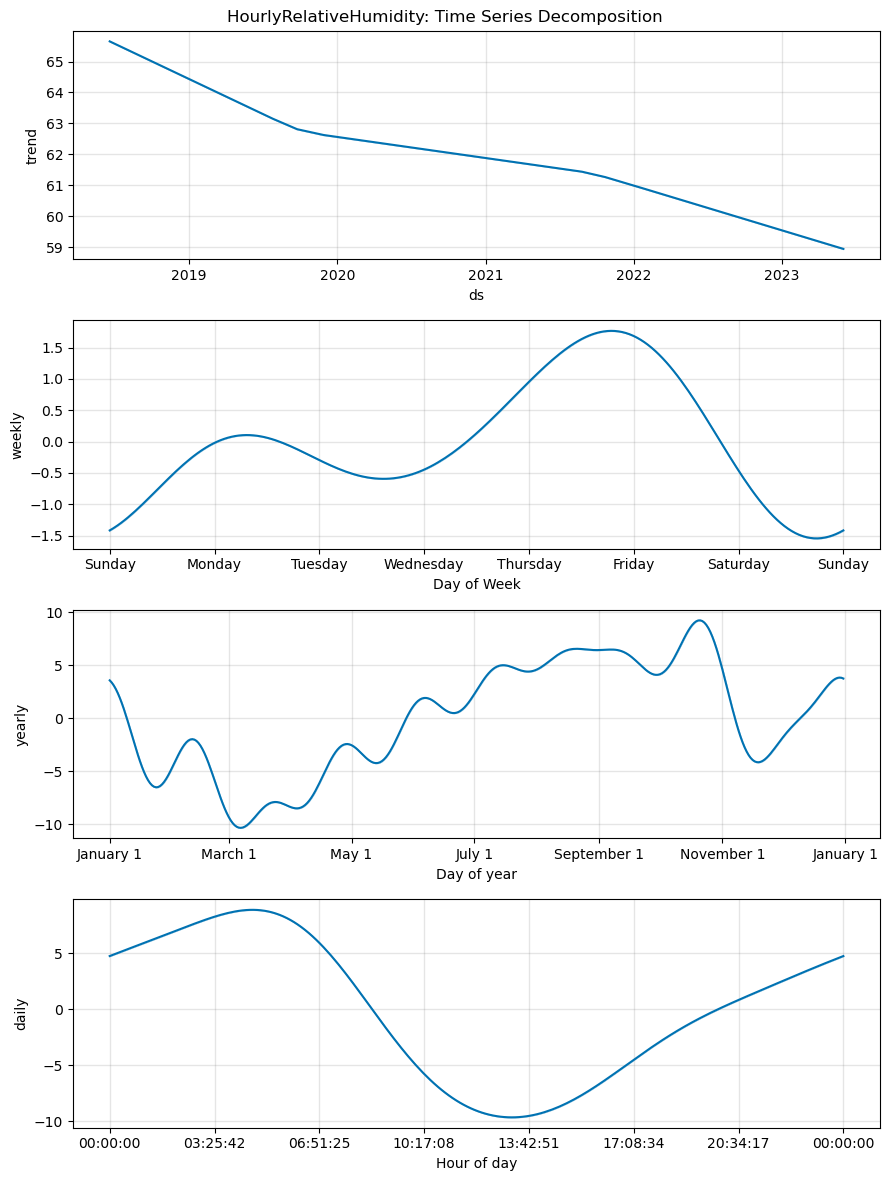

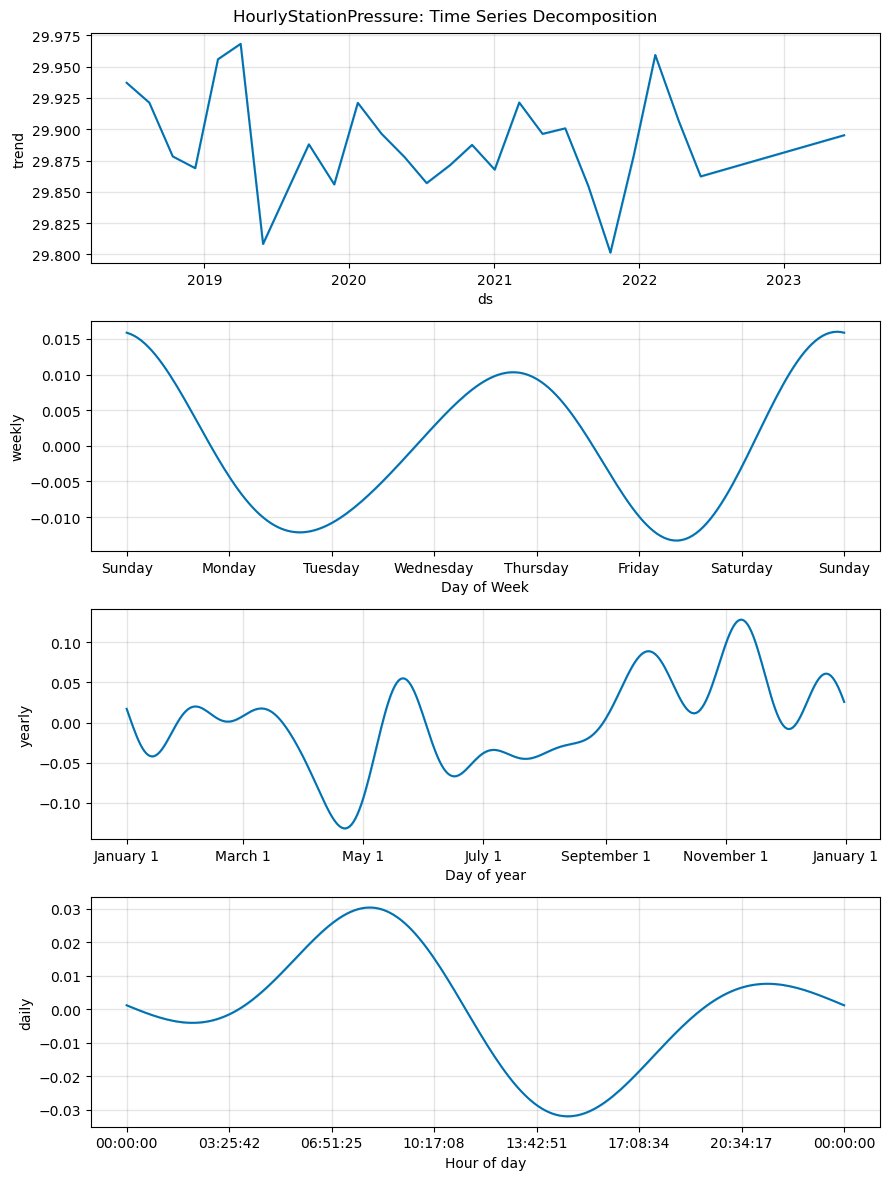

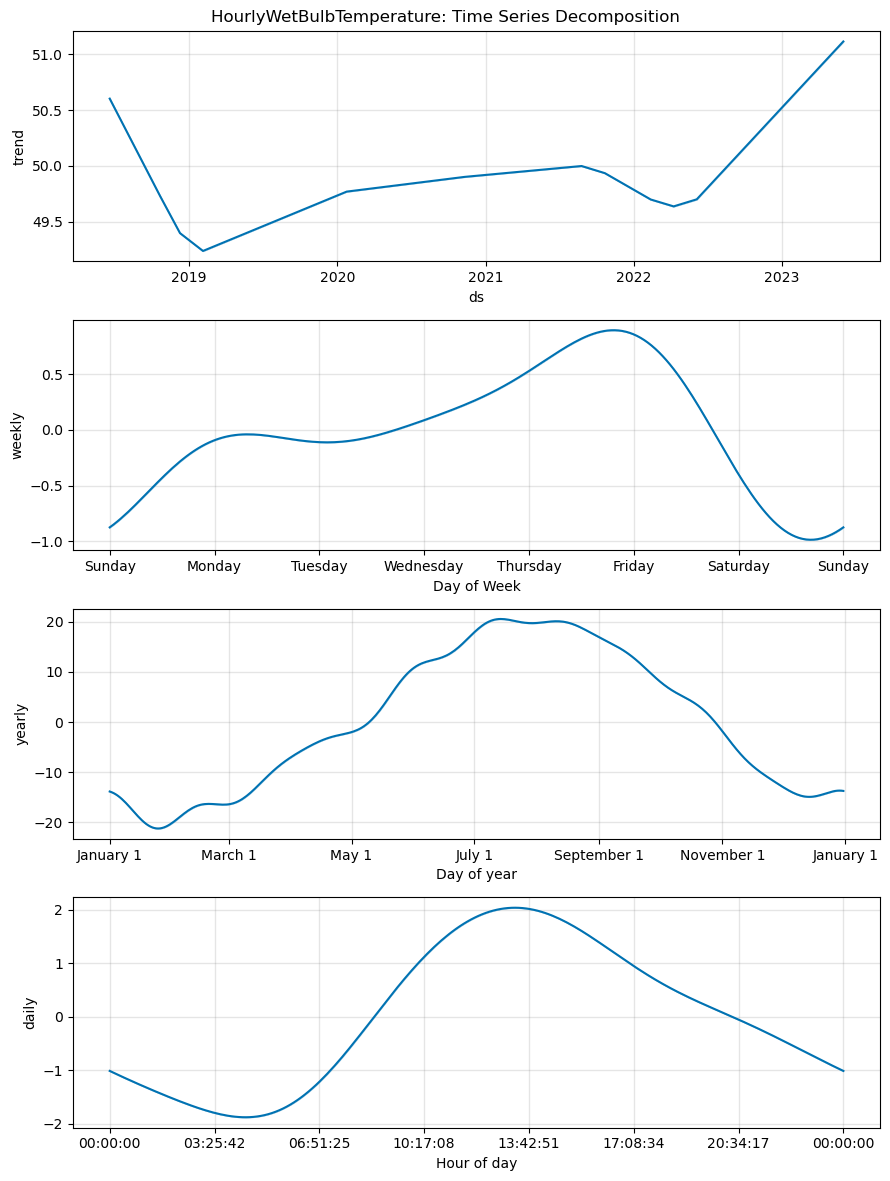

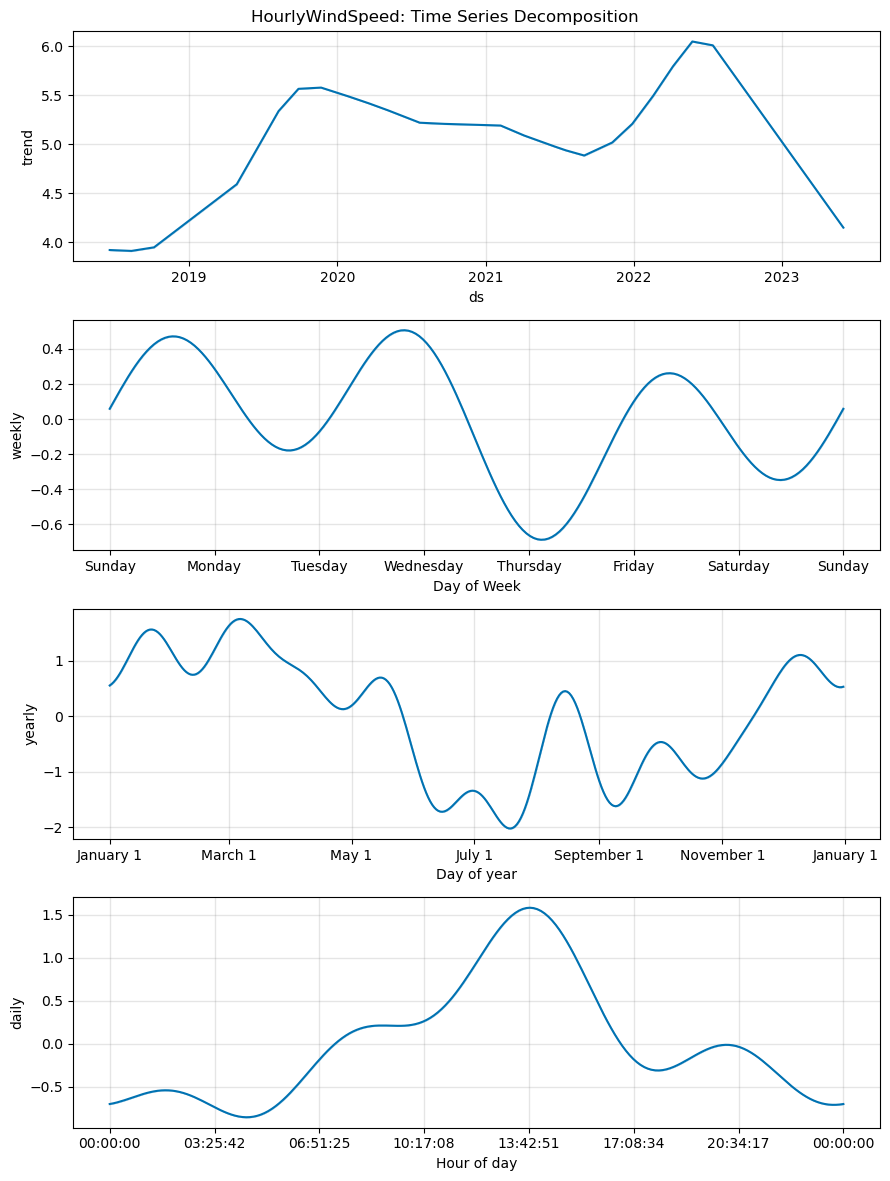

In [153]:
# for variable in clean_data.columns:
for variable in ["Energy Demand (MWH)", "HourlyDewPointTemperature", "HourlyDryBulbTemperature", "HourlyRelativeHumidity", "HourlyStationPressure", "HourlyWetBulbTemperature", "HourlyWindSpeed"]:
    fig = prophet_models[variable].plot_components(interpolations[variable])
    plt.suptitle(f"{variable}: Time Series Decomposition")
    plt.tight_layout()
    plt.show()

In [ ]:
# display(forecasts)
residuals = forecasts["yhat"] - df["y"]
# display(residuals)

Text(0.5, 1.0, 'Correlations Between Variables')

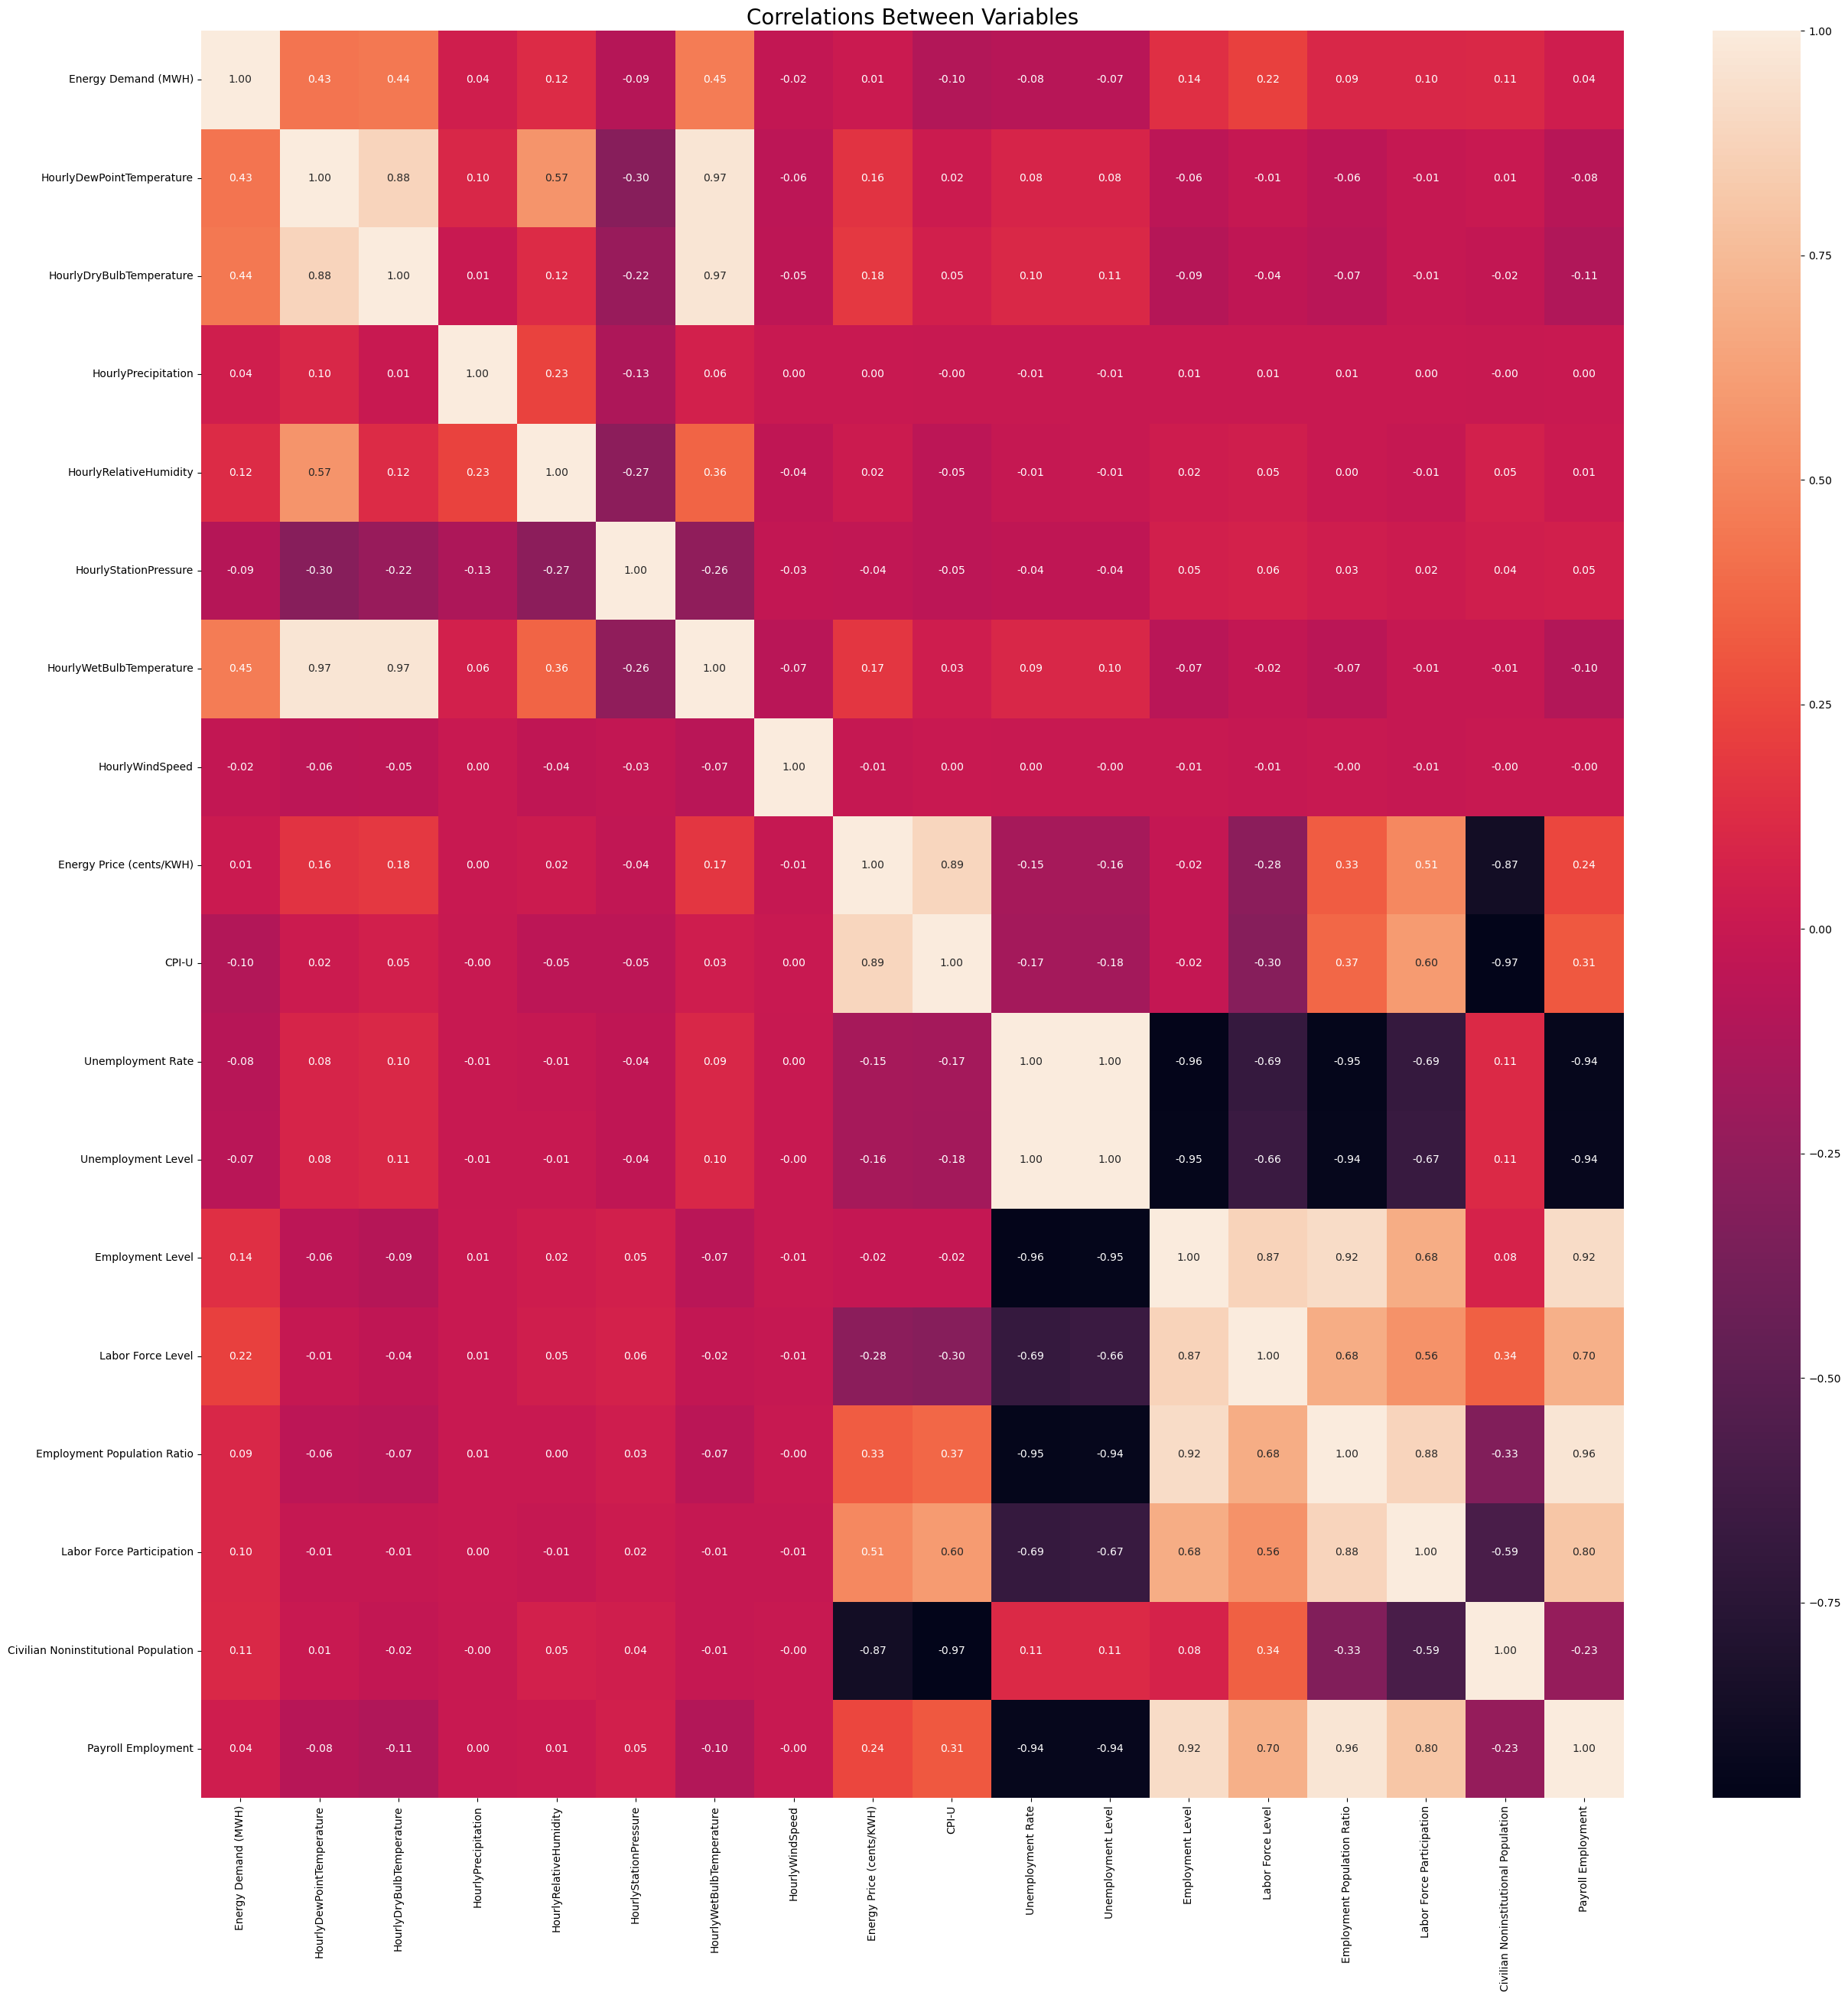

In [159]:
correlations = all_data.corr()
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot()
sns.heatmap(correlations, annot=True, fmt=".2f")
plt.fontsize=20
plt.title("Correlations Between Variables", size=20)